In [44]:
# Import statements
%pip install pykrige
%pip install xgboost
import random as rand
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
from skimage.feature import peak_local_max
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from pykrige.ok import OrdinaryKriging
from sklearn.preprocessing import MinMaxScaler

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


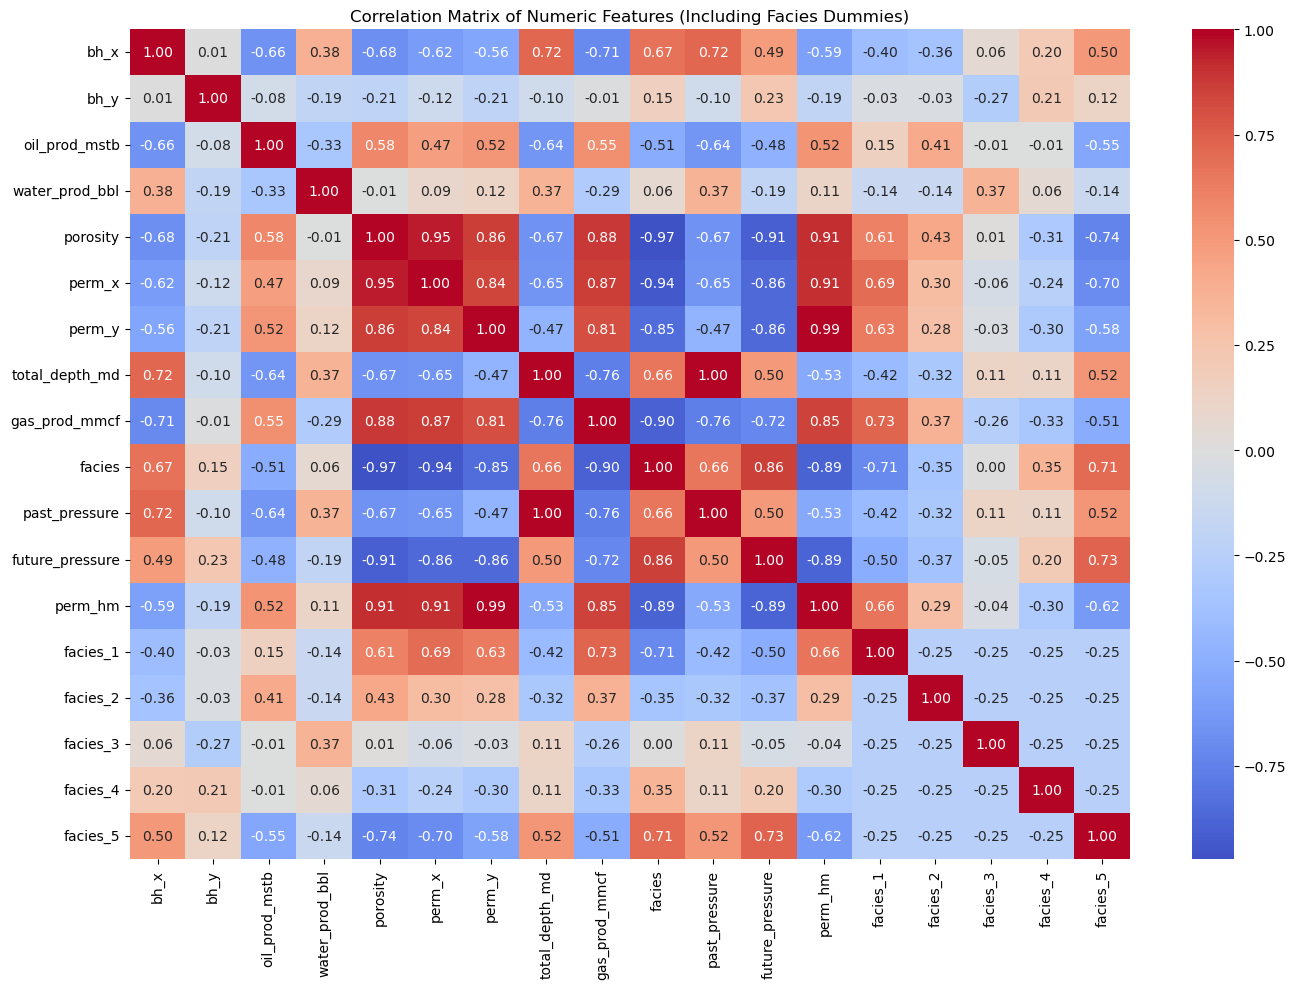

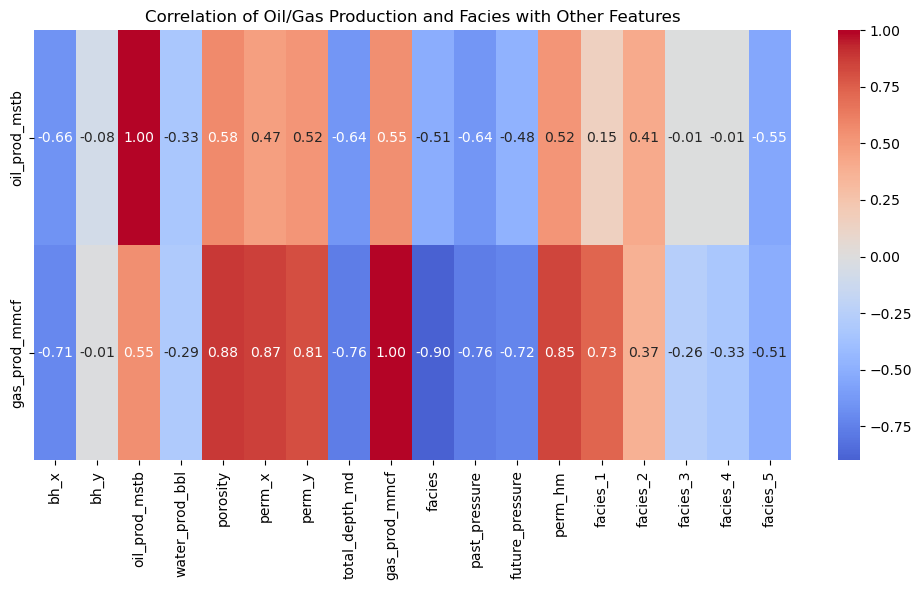

Dataset shape: (55, 13)
Scaled dataset shape: (55, 13)
Facies distribution:
facies
1    55
Name: count, dtype: int64


In [45]:
# Load dataset
df = pd.read_csv('sweetspot_UT_Austin.csv')

# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]': 'oil_prod_mstb',   # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)': 'water_prod_bbl',   # Cumulative water production, barrels
    'POROS': 'porosity',            # Porosity
    'KX': 'perm_x',                 # X permeability
    'KY': 'perm_y',                 # Y permeability
    'TD(MD)': 'total_depth_md',     # Total depth (measured depth)
    'Cg (mmcf)': 'gas_prod_mmcf',   # Gas production, million cubic feet
    'FACIES': 'facies',             # Facies
    'P_2020-1-6': 'past_pressure',  # Pressure on January 6, 2020
    'P_2029-1-1': 'future_pressure' # Predicted pressure on January 1, 2029
}
df.rename(columns=mappings, inplace=True)
# Add harmonic mean permeability to dataframe
df['perm_hm'] = 2 * df['perm_x'] * df['perm_y'] / (df['perm_x'] + df['perm_y'])

# One-hot encode facies for correlation analysis
facies_dummies = pd.get_dummies(df['facies'], prefix='facies', drop_first=False)
# Convert facies dummy variables to single categorical column BEFORE scaling
def get_facies_label(row):
    if row.get('facies_2', 0) == 1:
        return 2
    elif row.get('facies_3', 0) == 1:
        return 3
    elif row.get('facies_4', 0) == 1:
        return 4
    elif row.get('facies_5', 0) == 1:
        return 5
    else:
        return 1 
# Interpolate other features to grid using kriging
def krige_to_grid(df_in, feature, grid_x, grid_y):
    x = df_in['bh_x'].values
    y = df_in['bh_y'].values
    z = df_in[feature].values

    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x, y, z = x[mask], y[mask], z[mask]

    OK = OrdinaryKriging(
        x, y, z,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    z_pred, _ = OK.execute('grid', grid_x, grid_y)  # (len(grid_y), len(grid_x))
    return z_pred
columns_to_scale = ['total_depth_md', ]
# Replace inf and drop NaNs in scaled columns
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)
# Create scaled copy
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Keep facies as original integer labels
df_scaled['facies'] = df['facies'].astype(int)

# Build grid and krige depth
grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 150)
grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 150)
depth_grid = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)
numeric_df = df.select_dtypes(include=[np.number])
# Dataframe including numeric features and facies dummies
df_corr = pd.concat([numeric_df, facies_dummies], axis=1)
# Full correlation matrix including dummy facies
correlation_matrix = df_corr.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,        
    fmt=".2f",
    cmap='coolwarm',
    center=0
)
plt.title('Correlation Matrix of Numeric Features (Including Facies Dummies)')
plt.tight_layout()
plt.show()

# Correlation of oil and gas production (and/or facies dummies) with other features
rows_of_interest = ['oil_prod_mstb', 'gas_prod_mmcf']

plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix.loc[rows_of_interest, :],
    annot=True, fmt=".2f", cmap='coolwarm', center=0
)
plt.title('Correlation of Oil/Gas Production and Facies with Other Features')
plt.tight_layout()
plt.show()

# Create facies column in original df before scaling
df['facies'] = df.apply(get_facies_label, axis=1)

# Scale relevant columns
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 
                    'total_depth_md', 'water_prod_bbl']

# Replace inf values and drop rows with NaN in columns to scale
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)

# Create scaled dataframe
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Keep facies column in df_scaled (already created above)
df_scaled['facies'] = df['facies']

print(f"Dataset shape: {df.shape}")
print(f"Scaled dataset shape: {df_scaled.shape}")
print(f"Facies distribution:\n{df['facies'].value_counts().sort_index()}")

def create_kriging_plot(
    df, x_col, y_col, z_col, title='', 
    cmap='YlOrRd', add_contours=False, contour_col=None):    
    # Extract x, y, z for main map
    x = df[x_col].values
    y = df[y_col].values
    z = df[z_col].values
    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x, y, z = x[mask], y[mask], z[mask]

    # Build grid
    grid_x = np.linspace(x.min(), x.max(), 150)
    grid_y = np.linspace(y.min(), y.max(), 150)
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

    # Krige main variable
    OK = OrdinaryKriging(
        x, y, z,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )
    z_grid, _ = OK.execute('grid', grid_x, grid_y)   # shape (ny, nx)

    # Plot heatmap of kriged z
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(
        z_grid.T,
        extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
        origin='lower',
        cmap=cmap,
        aspect='auto',
        alpha=0.8
    )
    plt.colorbar(im, ax=ax, label=z_col.replace('_', ' ').title())

    # Color wells by kriged grid value at their position
    x_idx = np.searchsorted(grid_x, df[x_col])
    y_idx = np.searchsorted(grid_y, df[y_col])
    x_idx = np.clip(x_idx, 0, len(grid_x) - 1)
    y_idx = np.clip(y_idx, 0, len(grid_y) - 1)

    well_scores = z_grid[y_idx, x_idx]   # note: [row (y), col (x)]

    ax.scatter(
        df[x_col], df[y_col],
        c=well_scores,
        cmap=cmap,
        s=50,
        edgecolor='white',
        linewidth=1,
        alpha=0.8,
        label='Wells'
    )

    # kriged contours of another variable
    if add_contours and contour_col is not None:
        cx = df[x_col].values
        cy = df[y_col].values
        cz = df[contour_col].values
        mask_c = ~(np.isnan(cx) | np.isnan(cy) | np.isnan(cz))
        cx, cy, cz = cx[mask_c], cy[mask_c], cz[mask_c]

        OK_c = OrdinaryKriging(
            cx, cy, cz,
            variogram_model='spherical',
            verbose=False,
            enable_plotting=False
        )
        c_grid, _ = OK_c.execute('grid', grid_x, grid_y)

        contours = ax.contour(
            grid_x, grid_y, c_grid.T,
            colors='black', linewidths=1.5, levels=8, alpha=0.7
        )
        ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

    # Formatting
    ax.set_xlabel('X Coordinate', fontsize=18)
    ax.set_ylabel('Y Coordinate', fontsize=18)
    ax.set_title(title if title else f'{z_col.replace("_", " ").title()} Map', fontsize=22)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
    plt.tight_layout()
    return fig, ax, grid_x, grid_y, z_grid



In [46]:
# Size and top 8 rows in dataset
print('Data size:', df_scaled.shape)
df_scaled.head(n=8)

Data size: (55, 13)


bh_x      bh_y  oil_prod_mstb  water_prod_bbl  porosity    perm_x  \
0   5064.04  13746.23       0.457100    1.745744e-06  0.511559  0.020377   
1   7668.40  13746.23       0.228000    1.505296e-06  0.305572  0.015088   
2   2459.67  13746.23       0.400470    2.130768e-06  0.442178  0.022396   
3  10272.76  13746.23       0.004738    6.306559e-10  0.008303  0.000091   
4  12877.11  13746.23       0.003565    0.000000e+00  0.000000  0.000067   
5  10272.76  11141.88       0.008244    3.222393e-09  0.062447  0.000168   
6  11430.25  11141.88       0.001781    6.511770e-03  0.049650  0.000162   
7  12877.11  11141.88       0.000000    1.344031e-02  0.087970  0.000270   

     perm_y  total_depth_md  gas_prod_mmcf  facies  past_pressure  \
0  0.020377        0.353722       0.317559       1    3491.971374   
1  0.015088        0.435084       0.141138       1    3501.327981   
2  0.022396        0.369302       0.272412       1    3493.763065   
3  0.000091        0.595499       0.002226       1    3519.775759   
4  0.000067        0.835257       0.000879       1    3547.347889   
5  0.000168        0.364686       0.005643       1    3493.232193   
6  0.000162        0.461627       0.001058       1    3504.380491   
7  0.000270        0.604443       0.000000       1    3520.804323   

   future_pressure   perm_hm  
0      2992.403113  0.349677  
1      2947.374808  0.258610  
2      2904.053641  0.384431  
3      3301.826052  0.000422  
4      3365.597401  0.000000  
5      3196.746890  0.001740  
6      3126.405930  0.001640  
7      2949.434450  0.003495

In [47]:
# Missing value imputation

# Replace 0s with NaN 
df_scaled['oil_prod_mstb'] = df_scaled['oil_prod_mstb'].replace(0, np.nan)
df_scaled['gas_prod_mmcf'] = df_scaled['gas_prod_mmcf'].replace(0, np.nan)

# Median imputation (safer than mean due to outliers)
df_scaled['oil_prod_mstb'] = df_scaled['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median())
df_scaled['gas_prod_mmcf'] = df_scaled['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median())

C:\Users\shake\AppData\Local\Temp\ipykernel_34224\700364222.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])


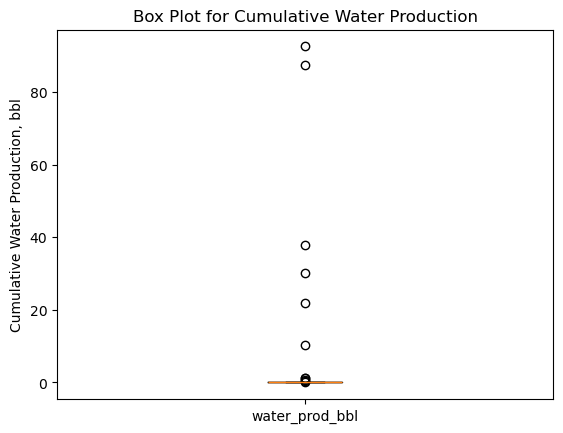

In [52]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

In [53]:
perm = 2 * df['perm_x'].astype(float) * df['perm_y'].astype(float) / (df['perm_x'].astype(float) + df['perm_y'].astype(float))
print(perm)

0     0.020377
1     0.015088
2     0.022396
3     0.000091
4     0.000067
5     0.000168
6     0.000162
7     0.000270
8     0.000284
9     0.015151
10    0.038947
11    0.050873
12    0.056463
13    0.052861
14    0.037831
15    0.034999
16    0.027062
17    0.019848
18    0.024499
19    0.013012
20    0.021804
21    0.012884
22    0.012158
23    0.004877
24    0.008402
25    0.009065
26    0.015409
27    0.012573
28    0.022922
29    0.053718
30    0.058151
31    0.047167
32    0.050863
33    0.036493
34    0.030338
35    0.038392
36    0.013927
37    0.004137
38    0.009499
39    0.003991
40    0.002784
41    0.004627
42    0.017898
43    0.026014
44    0.038956
45    0.038350
46    0.038000
47    0.041674
48    0.042639
49    0.055685
50    0.044984
51    0.034241
52    0.016377
53    0.012992
54    0.004627
dtype: float64


In [54]:
# Add harmonic mean permeability to dataframe
df['perm_hm'] = perm
df.head()

bh_x      bh_y  oil_prod_mstb  water_prod_bbl  porosity    perm_x  \
0   5064.04  13746.23      55.191600    1.617450e-04  0.128029  0.020377   
1   7668.40  13746.23      27.529400    1.394790e-04  0.101876  0.015088   
2   2459.67  13746.23      48.354000    1.973990e-04  0.119220  0.022396   
3  10272.76  13746.23       0.572057    1.440000e-07  0.064132  0.000091   
4  12877.11  13746.23       0.430394    8.560000e-08  0.063078  0.000067   

     perm_y  total_depth_md  gas_prod_mmcf  facies  past_pressure  \
0  0.020377          8551.7     157.119447       1    3491.971374   
1  0.015088          8579.9      69.831076       1    3501.327981   
2  0.022396          8557.1     134.781940       1    3493.763065   
3  0.000091          8635.5       1.101210       1    3519.775759   
4  0.000067          8718.6       0.435085       1    3547.347889   

   future_pressure   perm_hm  
0      2992.403113  0.020377  
1      2947.374808  0.015088  
2      2904.053641  0.022396  
3      3301.826052  0.000091  
4      3365.597401  0.000067

In [55]:
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 'total_depth_md', 'water_prod_bbl']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)
# Scale the relevant columns between 0 and 1
scale = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scale.fit_transform(df[columns_to_scale])

In [56]:
df_scaled.head()

bh_x      bh_y  oil_prod_mstb  water_prod_bbl  porosity    perm_x  \
0   5064.04  13746.23       0.457100    1.745744e-06  0.511559  0.020377   
1   7668.40  13746.23       0.228000    1.505296e-06  0.305572  0.015088   
2   2459.67  13746.23       0.400470    2.130768e-06  0.442178  0.022396   
3  10272.76  13746.23       0.004738    6.306559e-10  0.008303  0.000091   
4  12877.11  13746.23       0.003565    0.000000e+00  0.000000  0.000067   

     perm_y  total_depth_md  gas_prod_mmcf  facies  past_pressure  \
0  0.020377        0.353722       0.317559       1    3491.971374   
1  0.015088        0.435084       0.141138       1    3501.327981   
2  0.022396        0.369302       0.272412       1    3493.763065   
3  0.000091        0.595499       0.002226       1    3519.775759   
4  0.000067        0.835257       0.000879       1    3547.347889   

   future_pressure   perm_hm  
0      2992.403113  0.349677  
1      2947.374808  0.258610  
2      2904.053641  0.384431  
3      3301.826052  0.000422  
4      3365.597401  0.000000

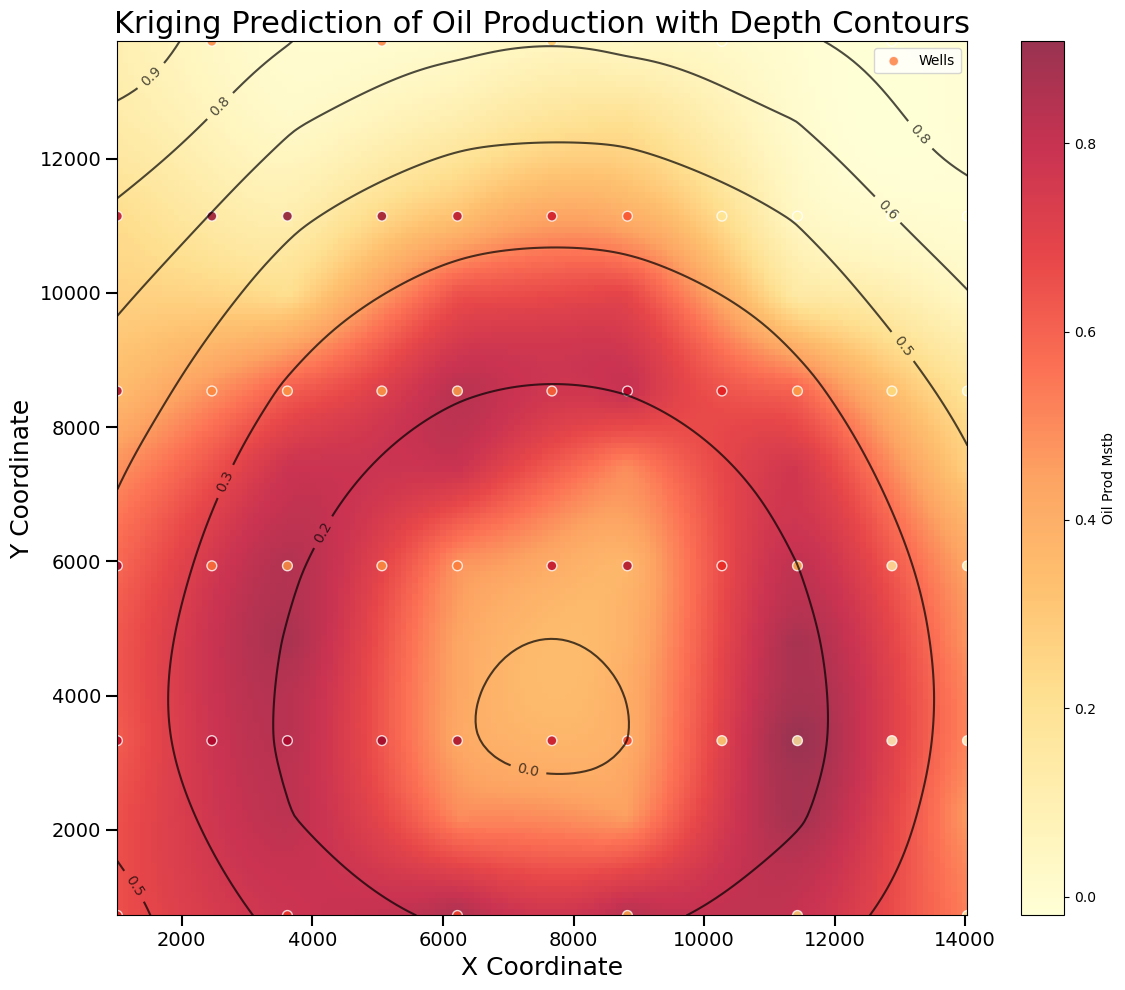

In [57]:
# Kriging plot of oil production with depth contours
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'oil_prod_mstb', 'Kriging Prediction of Oil Production with Depth Contours', cmap='YlOrRd', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

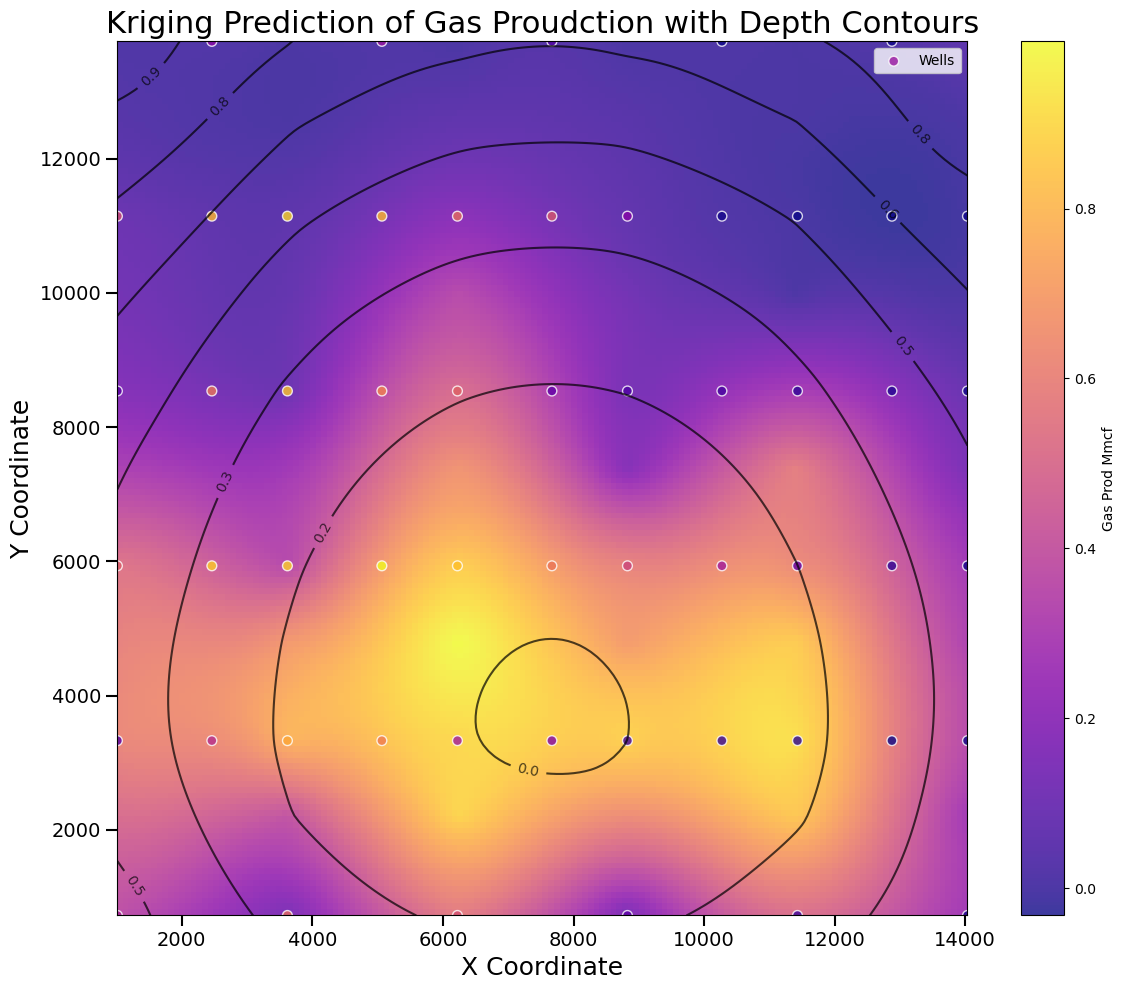

In [58]:
# Kriging interpolation and contour plotting (Gas Production)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'gas_prod_mmcf', 'Kriging Prediction of Gas Proudction with Depth Contours', cmap='plasma', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

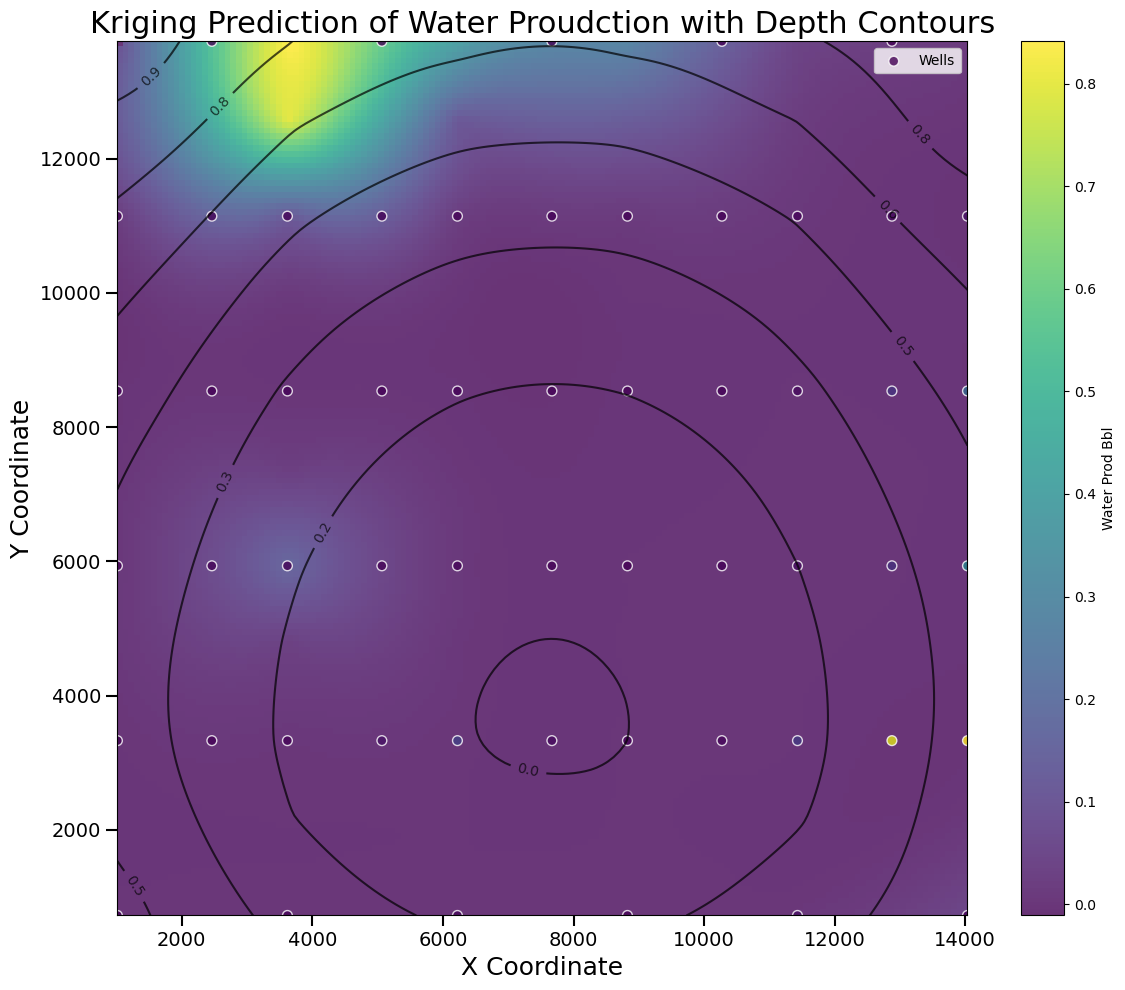

In [59]:
# Kriging interpolation and contour plotting (Water Production)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'water_prod_bbl', 'Kriging Prediction of Water Proudction with Depth Contours', cmap='viridis', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

In [60]:
# Define top-performing wells (top quartile)
top_oil_threshold = df_scaled['oil_prod_mstb'].quantile(0.75)
top_gas_threshold = df_scaled['gas_prod_mmcf'].quantile(0.75)

df_scaled['top_oil_well'] = df_scaled['oil_prod_mstb'] >= top_oil_threshold
df_scaled['top_gas_well'] = df_scaled['gas_prod_mmcf'] >= top_gas_threshold

# Check if facies dummy columns exist
facies_cols = ['facies_2', 'facies_3', 'facies_4', 'facies_5']

if all(col in df_scaled.columns for col in facies_cols):
    # If dummy columns exist, use them
    print('Facies sums in top oil wells:')
    print(df_scaled.loc[df_scaled['top_oil_well'], facies_cols].sum())
    print('\nFacies sums in top gas wells:')
    print(df_scaled.loc[df_scaled['top_gas_well'], facies_cols].sum())
else:
    # If dummy columns don't exist, use the 'facies' column instead
    print('Facies distribution in top oil wells:')
    print(df_scaled.loc[df_scaled['top_oil_well'], 'facies'].value_counts().sort_index())
    print('\nFacies distribution in top gas wells:')
    print(df_scaled.loc[df_scaled['top_gas_well'], 'facies'].value_counts().sort_index())
    
    # Also show as percentages
    print('\nFacies percentages in top oil wells:')
    print(df_scaled.loc[df_scaled['top_oil_well'], 'facies'].value_counts(normalize=True).sort_index() * 100)
    print('\nFacies percentages in top gas wells:')
    print(df_scaled.loc[df_scaled['top_gas_well'], 'facies'].value_counts(normalize=True).sort_index() * 100)

Facies distribution in top oil wells:
facies
1    14
Name: count, dtype: int64

Facies distribution in top gas wells:
facies
1    14
Name: count, dtype: int64

Facies percentages in top oil wells:
facies
1    100.0
Name: proportion, dtype: float64

Facies percentages in top gas wells:
facies
1    100.0
Name: proportion, dtype: float64


In [61]:
# Porosity & permeability stats in top wells
print('\nPorosity in top oil wells:')
print(df[df_scaled['top_oil_well']]['porosity'].describe())
print('\nPermeability in top oil wells:')
print(df[df_scaled['top_oil_well']]['perm_hm'].describe())


Porosity in top oil wells:
count    14.000000
mean      0.164826
std       0.020093
min       0.117819
25%       0.158312
50%       0.169857
75%       0.176481
max       0.188017
Name: porosity, dtype: float64

Permeability in top oil wells:
count    14.000000
mean      0.036894
std       0.013158
min       0.012158
25%       0.031877
50%       0.038669
75%       0.042398
max       0.056463
Name: perm_hm, dtype: float64


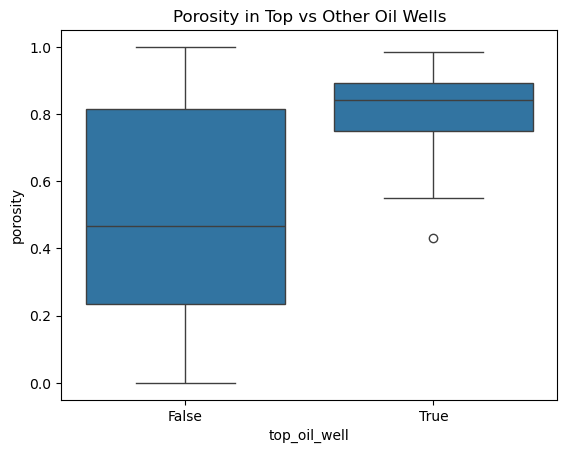

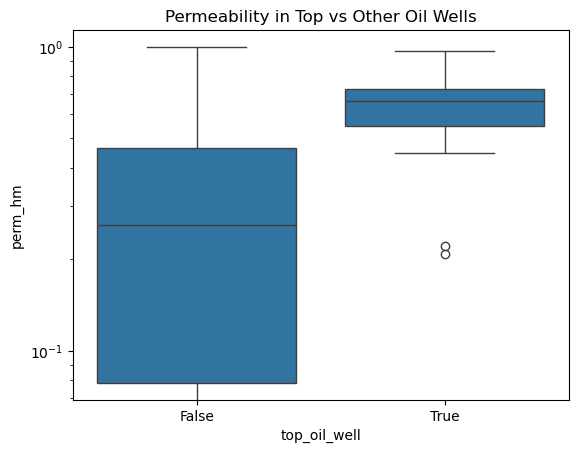

In [62]:
# Visualize distributions
sns.boxplot(data=df_scaled, x='top_oil_well', y='porosity')
plt.title('Porosity in Top vs Other Oil Wells')
plt.show()

sns.boxplot(data=df_scaled, x='top_oil_well', y='perm_hm')
plt.yscale('log')
plt.title('Permeability in Top vs Other Oil Wells')
plt.show()

array([[<Axes: title={'center': 'oil_prod_mstb'}>,
        <Axes: title={'center': 'gas_prod_mmcf'}>]], dtype=object)

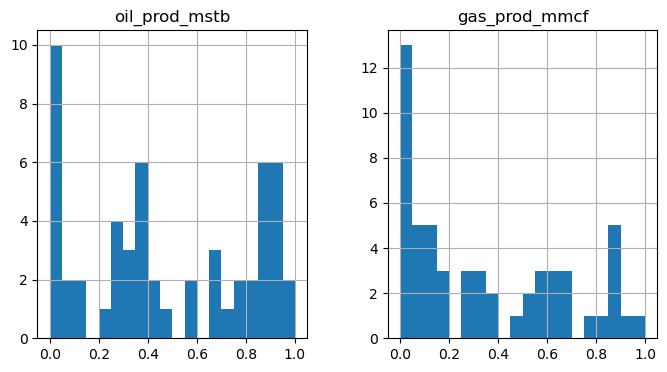

In [63]:
# Histograms
df_scaled[['oil_prod_mstb','gas_prod_mmcf']].hist(bins=20, figsize=(8,4))

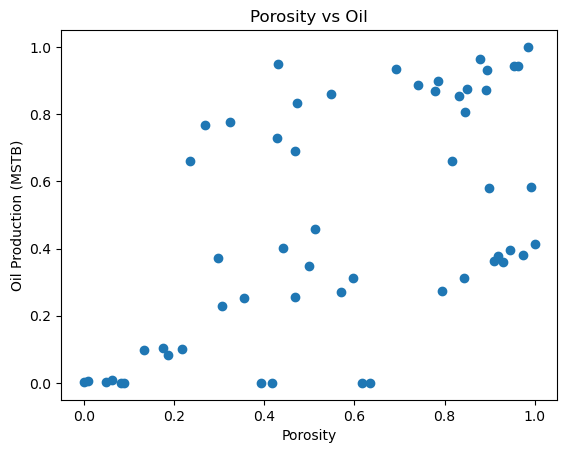

In [64]:
# Scatter plot of porosity vs oil production
plt.scatter(df_scaled['porosity'], df_scaled['oil_prod_mstb'])
plt.xlabel('Porosity'); plt.ylabel('Oil Production (MSTB)'); plt.title('Porosity vs Oil')
plt.show()

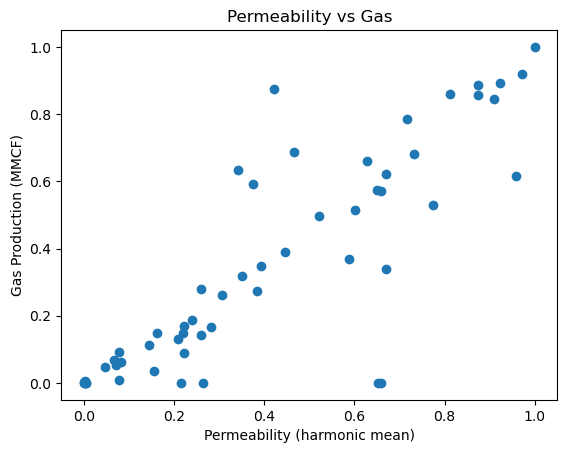

In [65]:
# Scatter plot of permeability vs gas production
plt.scatter(df_scaled['perm_hm'], df_scaled['gas_prod_mmcf'])
plt.xlabel('Permeability (harmonic mean)'); plt.ylabel('Gas Production (MMCF)'); plt.title('Permeability vs Gas')
plt.show()

In [67]:
# Reload raw data
df = pd.read_csv('sweetspot_UT_Austin.csv')

# Drop redundant identifiers
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

# Rename columns (this brings FACIES -> facies)
mappings = {
    'Bottomhole X': 'bh_x',
    'Bottomhole Y': 'bh_y',
    'Co [MSTB]': 'oil_prod_mstb',
    'Cw (bbl)': 'water_prod_bbl',
    'POROS': 'porosity',
    'KX': 'perm_x',
    'KY': 'perm_y',
    'TD(MD)': 'total_depth_md',
    'Cg (mmcf)': 'gas_prod_mmcf',
    'FACIES': 'facies',
    'P_2020-1-6': 'past_pressure',
    'P_2029-1-1': 'future_pressure'
}
df.rename(columns=mappings, inplace=True)
# Derived permeability
df['perm_hm'] = 2 * df['perm_x'] * df['perm_y'] / (df['perm_x'] + df['perm_y'])

columns_to_scale = [
    'perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf',
    'total_depth_md', 'water_prod_bbl'
]

# Clean and scale
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)

df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# facies stays as integer labels
df_scaled['facies'] = df['facies'].astype(int)

print(df_scaled.columns)         # should include 'facies'
print(df_scaled['facies'].unique())
top_oil = df_scaled.nlargest(10, 'oil_prod_mstb')
print("Facies counts among top 10 oil producers:")
print(top_oil['facies'].value_counts())
facies_dummies = pd.get_dummies(df_scaled['facies'], prefix='facies', drop_first=False)
df_scaled = pd.concat([df_scaled, facies_dummies], axis=1)
# Check facies is present
print(df['facies'].unique())
# One-hot encode facies since it is categorical
df = pd.get_dummies(df_scaled, columns=['facies'], drop_first=True)
top_oil = df.nlargest(10, 'oil_prod_mstb')
print(top_oil[['facies_2','facies_3','facies_4','facies_5']].sum())

Index(['bh_x', 'bh_y', 'oil_prod_mstb', 'water_prod_bbl', 'porosity', 'perm_x',
       'perm_y', 'total_depth_md', 'gas_prod_mmcf', 'facies', 'past_pressure',
       'future_pressure', 'perm_hm'],
      dtype='object')
[3 4 5 2 1]
Facies counts among top 10 oil producers:
facies
2    4
1    3
3    2
4    1
Name: count, dtype: int64
[3 4 5 2 1]
facies_2    4
facies_2    4
facies_3    2
facies_3    2
facies_4    1
facies_4    1
facies_5    0
facies_5    0
dtype: int64


In [68]:
# Display top 5 wells by oil production
top_wells = df_scaled.nlargest(5, 'oil_prod_mstb')[['bh_x', 'bh_y', 'oil_prod_mstb', 'gas_prod_mmcf',
                                             'perm_hm', 'porosity', 'total_depth_md', 'past_pressure'] + facies_cols]
print(top_wells)

       bh_x      bh_y  oil_prod_mstb  gas_prod_mmcf   perm_hm  porosity  \
12  3617.17  11141.88       1.000000       0.919680  0.970942  0.984023   
35  1012.81   5933.16       0.963526       0.569751  0.659820  0.878828   
22  8825.89   8537.52       0.948946       0.129526  0.208175  0.431142   
11  5064.04  11141.88       0.943359       0.857965  0.874694  0.952730   
13  2459.67  11141.88       0.942920       0.843898  0.908931  0.961838   

    total_depth_md  past_pressure  facies_2  facies_3  facies_4  facies_5  
12        0.111945    3464.166989     False     False     False     False  
35        0.131852    3466.456371      True     False     False     False  
22        0.153780    3468.978010     False     False      True     False  
11        0.122908    3465.427808     False     False     False     False  
13        0.138488    3467.219499     False     False     False     False  


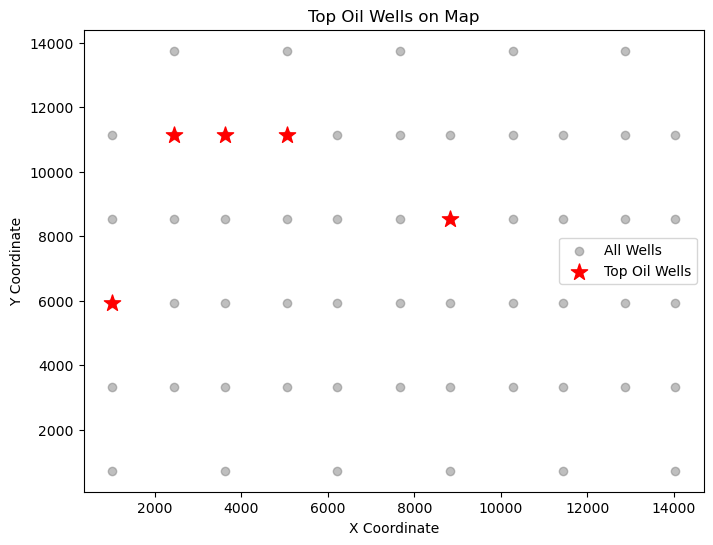

In [69]:
# Plot top oil wells on map
plt.figure(figsize=(8, 6))
plt.scatter(df['bh_x'], df['bh_y'], c='gray', alpha=0.5, label='All Wells')
plt.scatter(top_wells['bh_x'], top_wells['bh_y'], c='r', marker='*', s=150, label='Top Oil Wells')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Top Oil Wells on Map')
plt.legend()
plt.show()

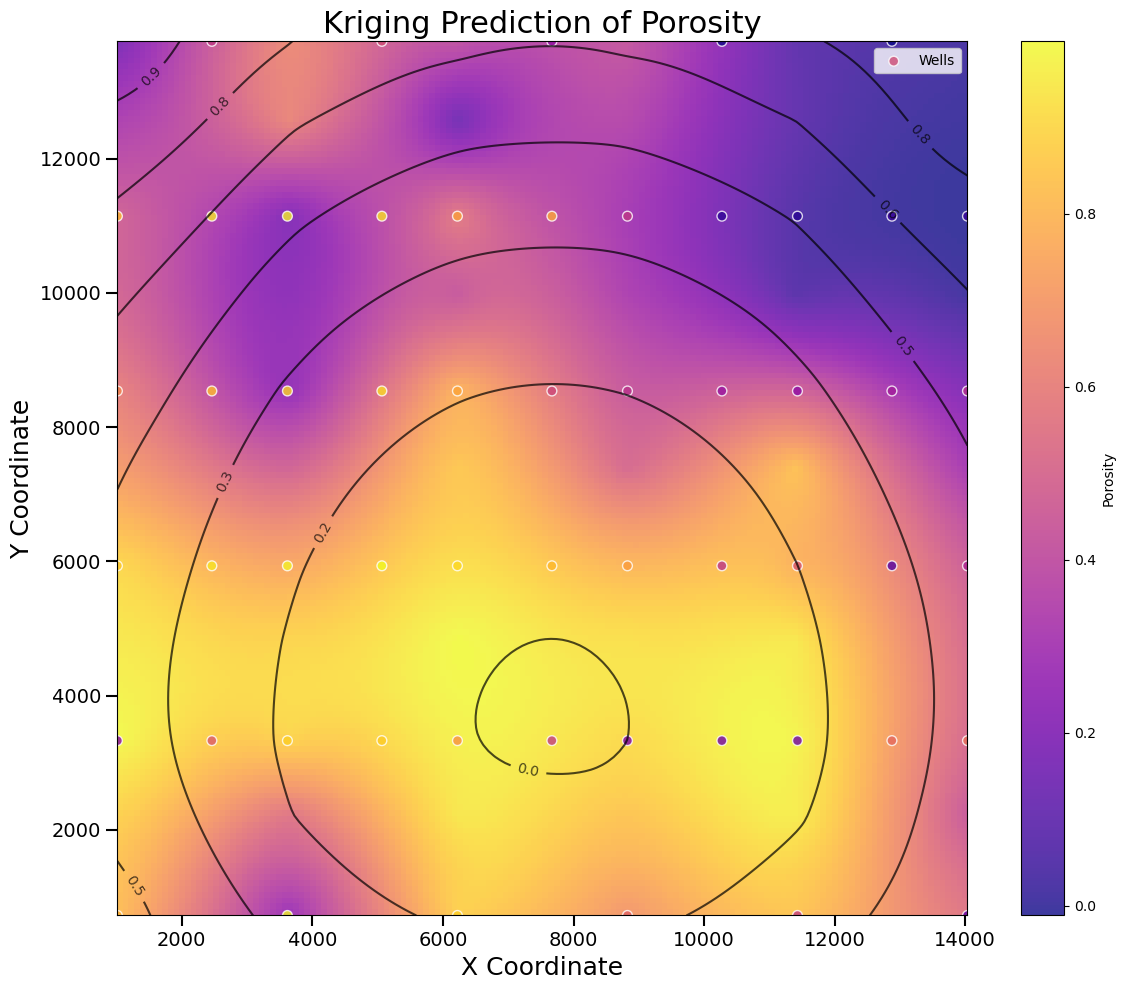

In [70]:
# Kriging plot for porosity
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'porosity', 
                    'Kriging Prediction of Porosity',
                    cmap='plasma', add_contours=True, contour_col='total_depth_md')
plt.show()

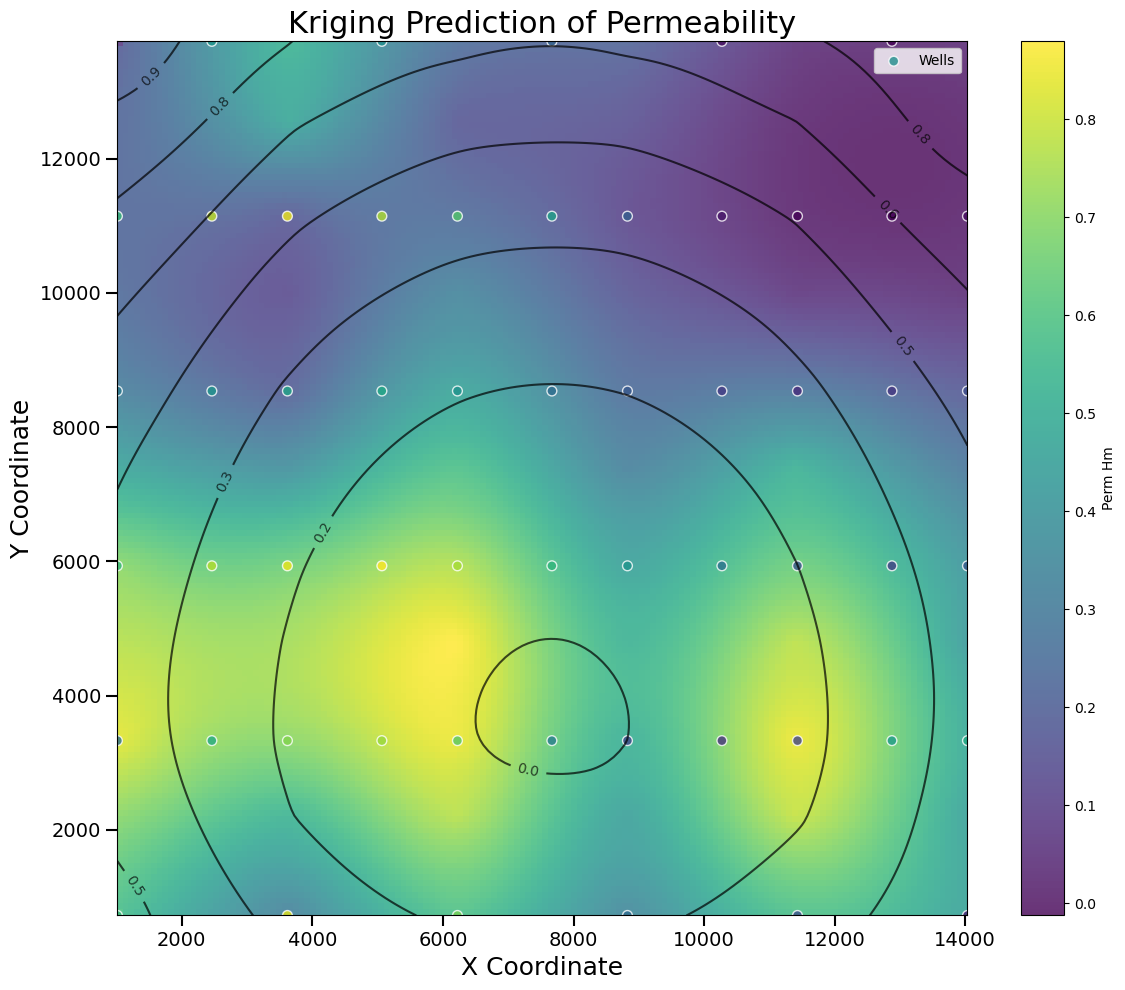

In [71]:
# Kriging plot for permeability
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'perm_hm', 
                    'Kriging Prediction of Permeability',
                    cmap='viridis', add_contours=True, contour_col='total_depth_md')
plt.show()

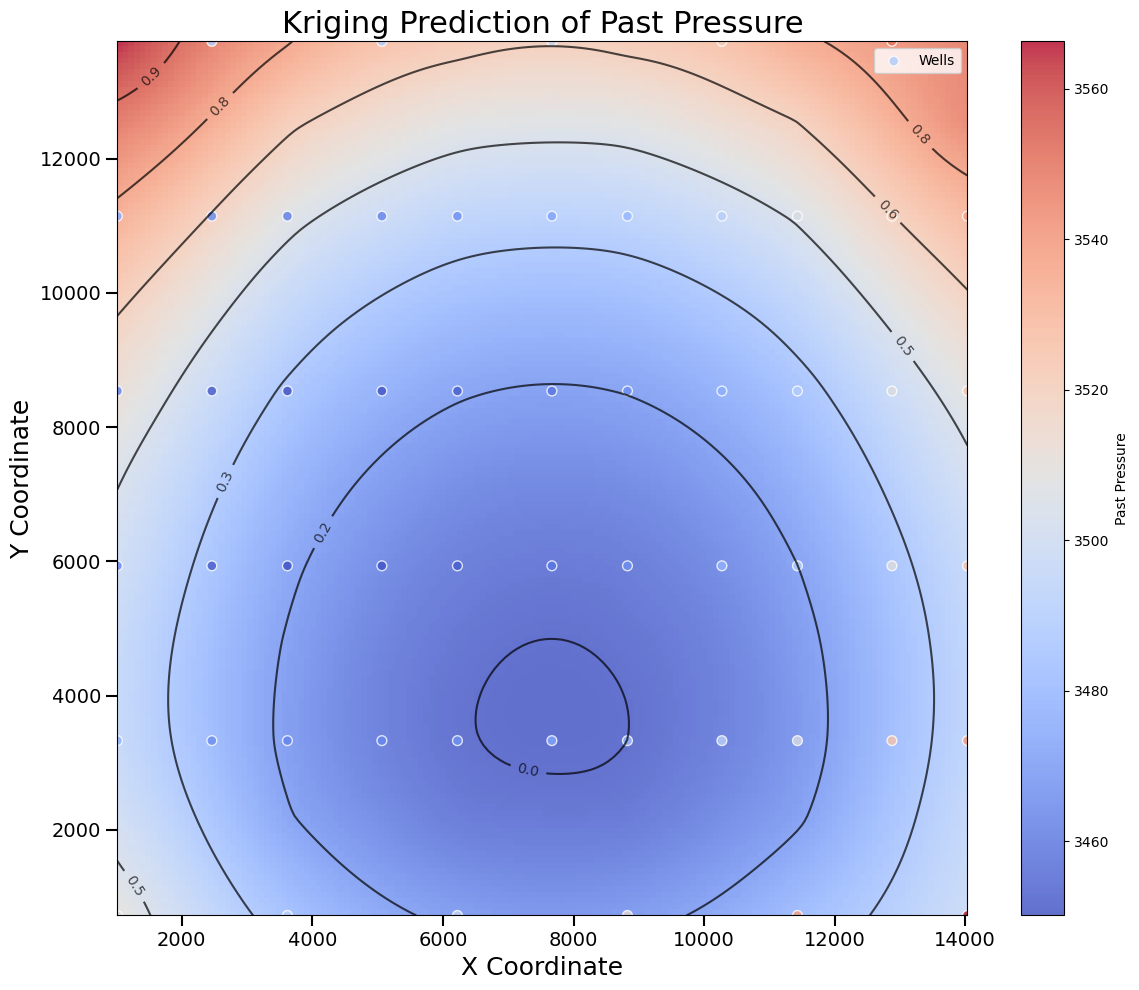

In [72]:
# Kriging plot for past pressure
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'past_pressure', 
                    'Kriging Prediction of Past Pressure',
                    cmap='coolwarm', add_contours=True, contour_col='total_depth_md')
plt.show()

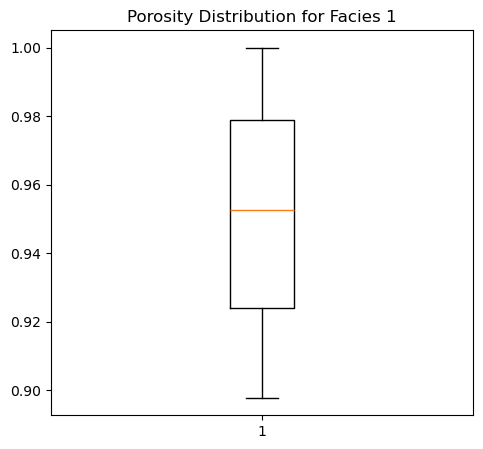

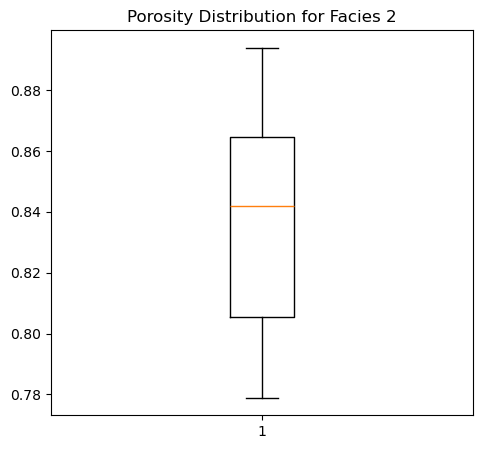

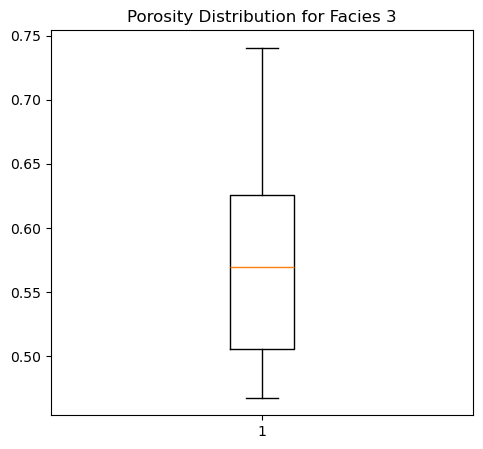

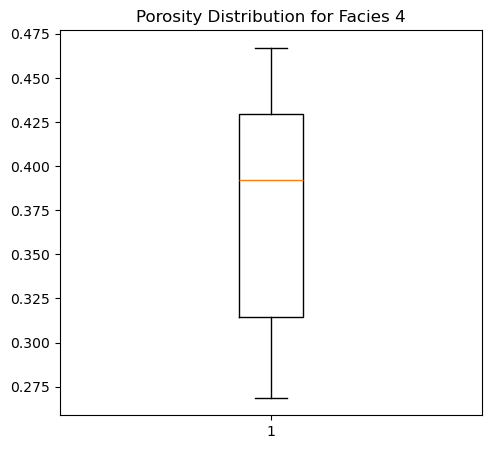

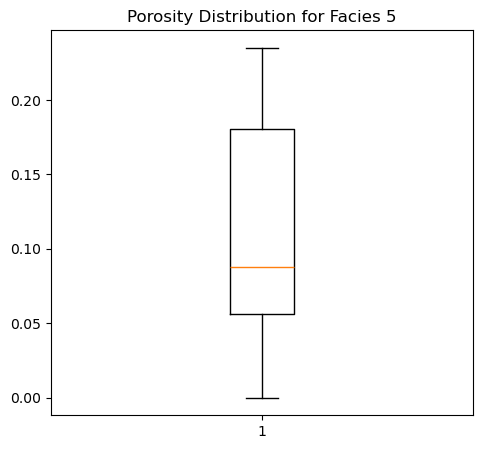

In [73]:
# Box plots of porosity by each facies class
facies_classes = sorted(df_scaled['facies'].unique())
for facies in facies_classes:
    subset = df_scaled[df_scaled['facies']==facies]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.boxplot(subset['porosity'], label=[f'Facies {facies}'])
    plt.title(f'Porosity Distribution for Facies {facies}')
    

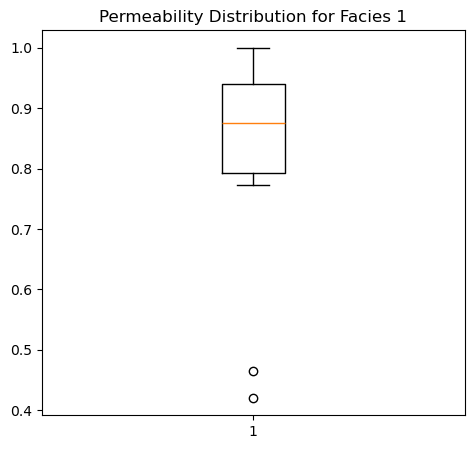

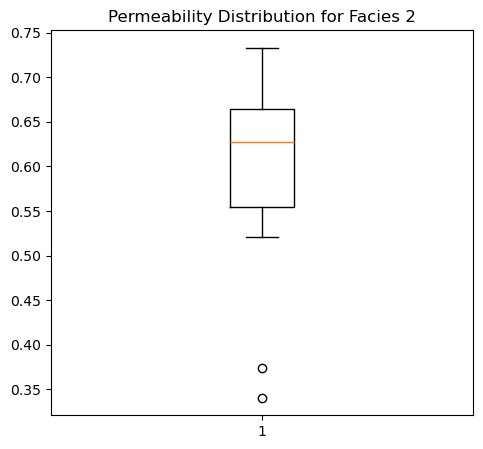

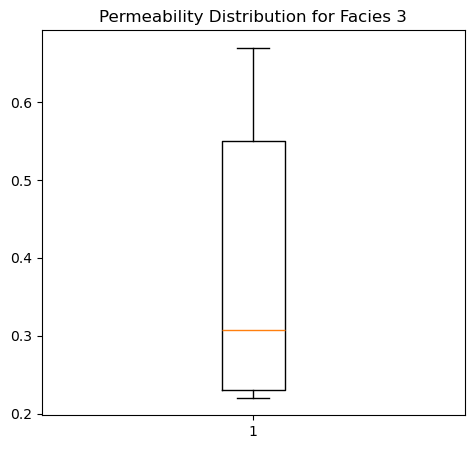

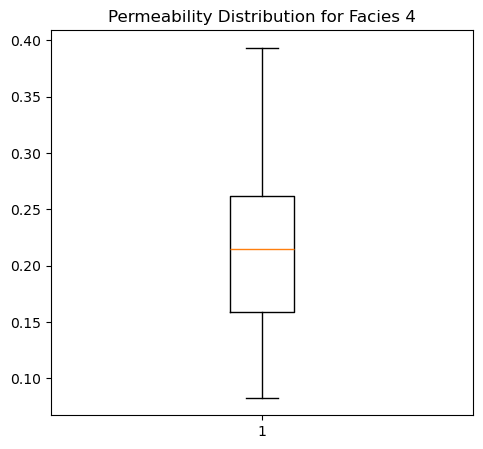

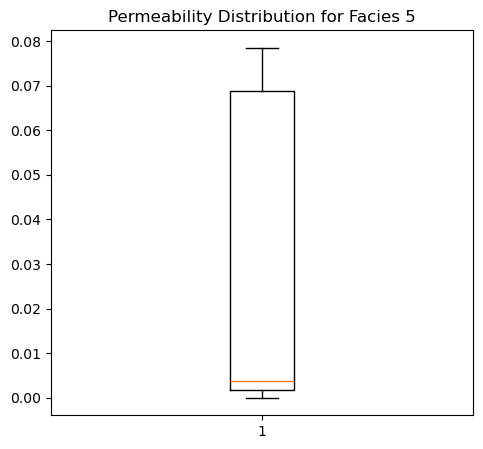

In [74]:
# Box plots of porosity and permeability by each facies class
for facies in facies_classes:
    subset = df_scaled[df_scaled['facies']==facies]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.boxplot(subset['perm_hm'], label=[f'Facies {facies}'])
    plt.title(f'Permeability Distribution for Facies {facies}')

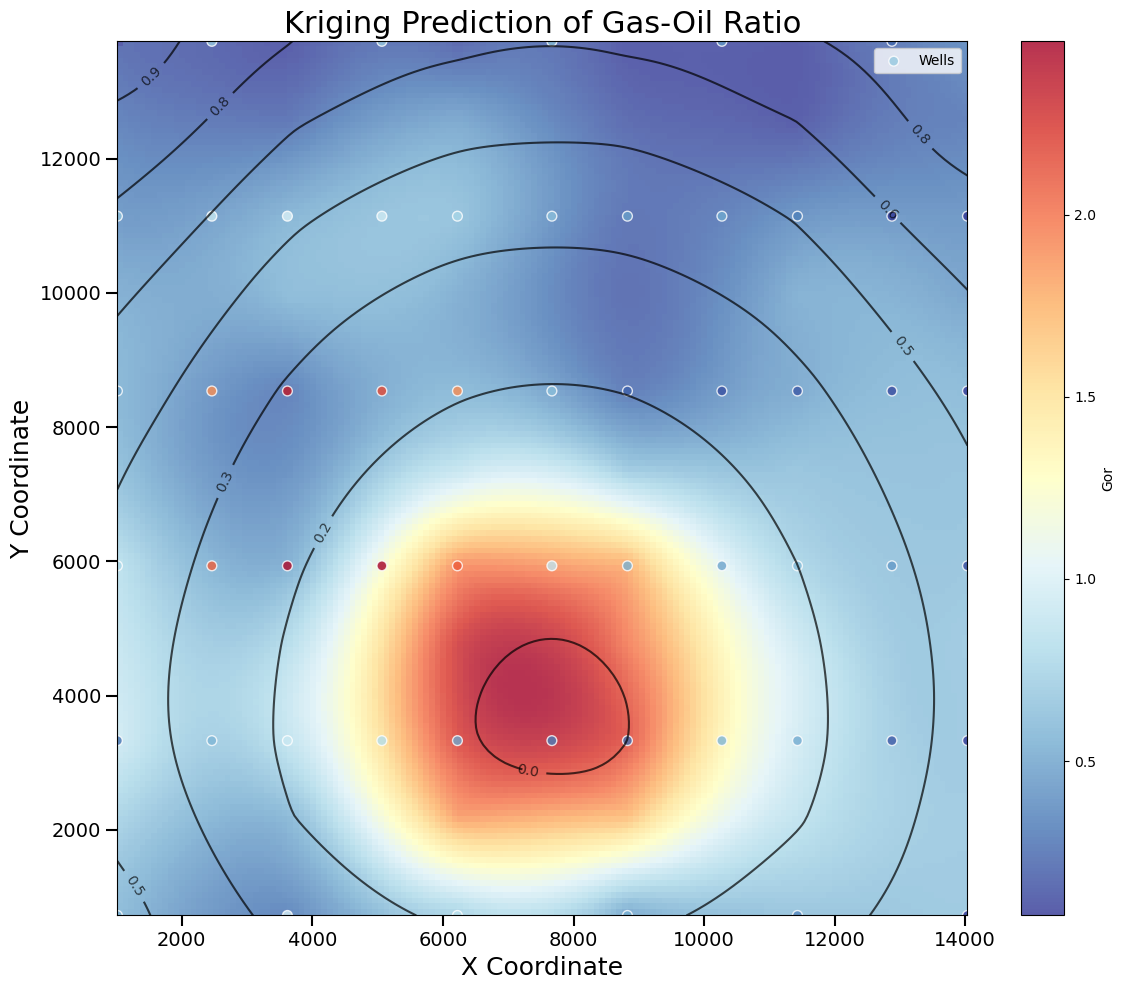

In [ ]:
# Classify wells by fluid dominance using GOR
df_scaled['GOR'] = df_scaled['gas_prod_mmcf'] / (df_scaled['oil_prod_mstb'] + 0.001)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'GOR', 
                    'Kriging Prediction of Gas-Oil Ratio',
                    cmap='RdYlBu_r', add_contours=True, contour_col='total_depth_md')
plt.show()

In [75]:
# Features for facies prediction
feature_cols = ['bh_x', 'bh_y', 'total_depth_md', 'porosity', 'perm_hm', 'past_pressure']

X = df_scaled[feature_cols].copy()
y = df_scaled['facies'].copy()

# Handle any missing values
X = X.fillna(X.median())

# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_classifier.fit(X_train, y_train)

# Evaluate
train_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)

print(f"Training Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")
print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


Training Accuracy: 1.000
Test Accuracy: 1.000
Cross-validation Accuracy: 0.855 (+/- 0.123)


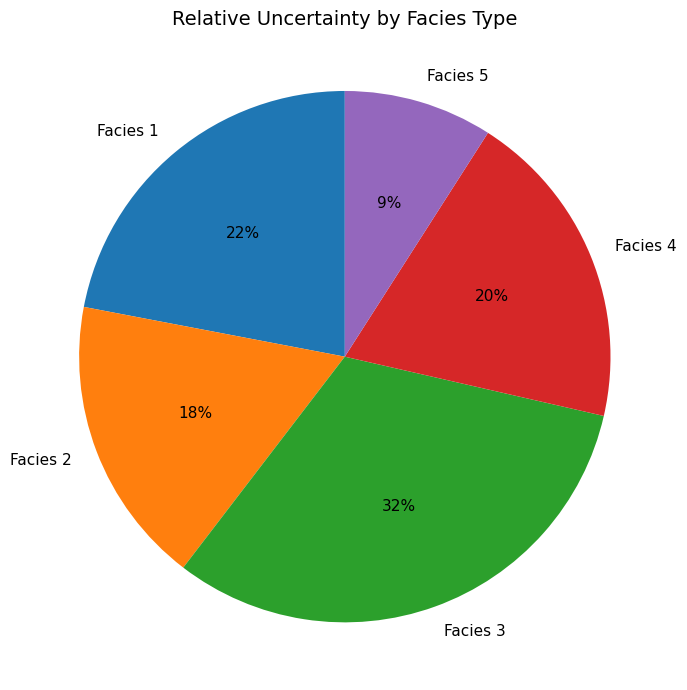

In [76]:
# Get predicted class probabilities
proba = rf_classifier.predict_proba(X)          # shape (n_samples, n_classes)
classes = rf_classifier.classes_                      # array of facies labels

# For each sample, probability assigned to its true facies
true_class_index = np.array([np.where(classes == f)[0][0] for f in y])
true_proba = proba[np.arange(len(y)), true_class_index]

# Define uncertainty as 1 - p(true facies)
sample_uncertainty = 1.0 - true_proba

# Aggregate mean uncertainty per facies
facies_uncertainty = []
for fac in classes:
    mask = (y == fac)
    facies_uncertainty.append(sample_uncertainty[mask].mean())

facies_uncertainty = np.array(facies_uncertainty)

# Normalize to sum to 100% for a pie chart
sizes = facies_uncertainty / facies_uncertainty.sum() * 100
labels = [f'Facies {fac}' for fac in classes]

# Plot pie chart
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.0f%%',
    startangle=90,
    textprops={'fontsize': 11}
)
ax.set_title('Relative Uncertainty by Facies Type', fontsize=14)
ax.axis('equal')
plt.tight_layout()
plt.show()

In [77]:
# Check for common samples in train/test
common_indices = set(X_train.index).intersection(set(X_test.index))
print("Common samples in train/test:", common_indices)

Common samples in train/test: set()


In [78]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance for Facies Prediction:")
print(feature_importance)


Feature Importance for Facies Prediction:
          feature  importance
3        porosity    0.404179
4         perm_hm    0.248877
5   past_pressure    0.124186
2  total_depth_md    0.118549
0            bh_x    0.066057
1            bh_y    0.038152


In [79]:
# Create dense grid over field
x_min, x_max = df['bh_x'].min(), df['bh_x'].max()
y_min, y_max = df['bh_y'].min(), df['bh_y'].max()

grid_x = np.linspace(x_min, x_max, 100)
grid_y = np.linspace(y_min, y_max, 100)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

In [80]:
# Krige all features
grid_depth = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)
grid_porosity = krige_to_grid(df_scaled, 'porosity', grid_x, grid_y)
grid_perm = krige_to_grid(df_scaled, 'perm_hm', grid_x, grid_y)
grid_pressure = krige_to_grid(df_scaled, 'past_pressure', grid_x, grid_y)

In [81]:
# Prepare grid features for prediction
grid_features = np.column_stack([
    grid_xx.ravel(),
    grid_yy.ravel(),
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel()
])

# Predict facies class
facies_pred = rf_classifier.predict(grid_features)
facies_pred_grid = facies_pred.reshape(grid_xx.shape)

# Predict probabilities for each facies
facies_proba = rf_classifier.predict_proba(grid_features)

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


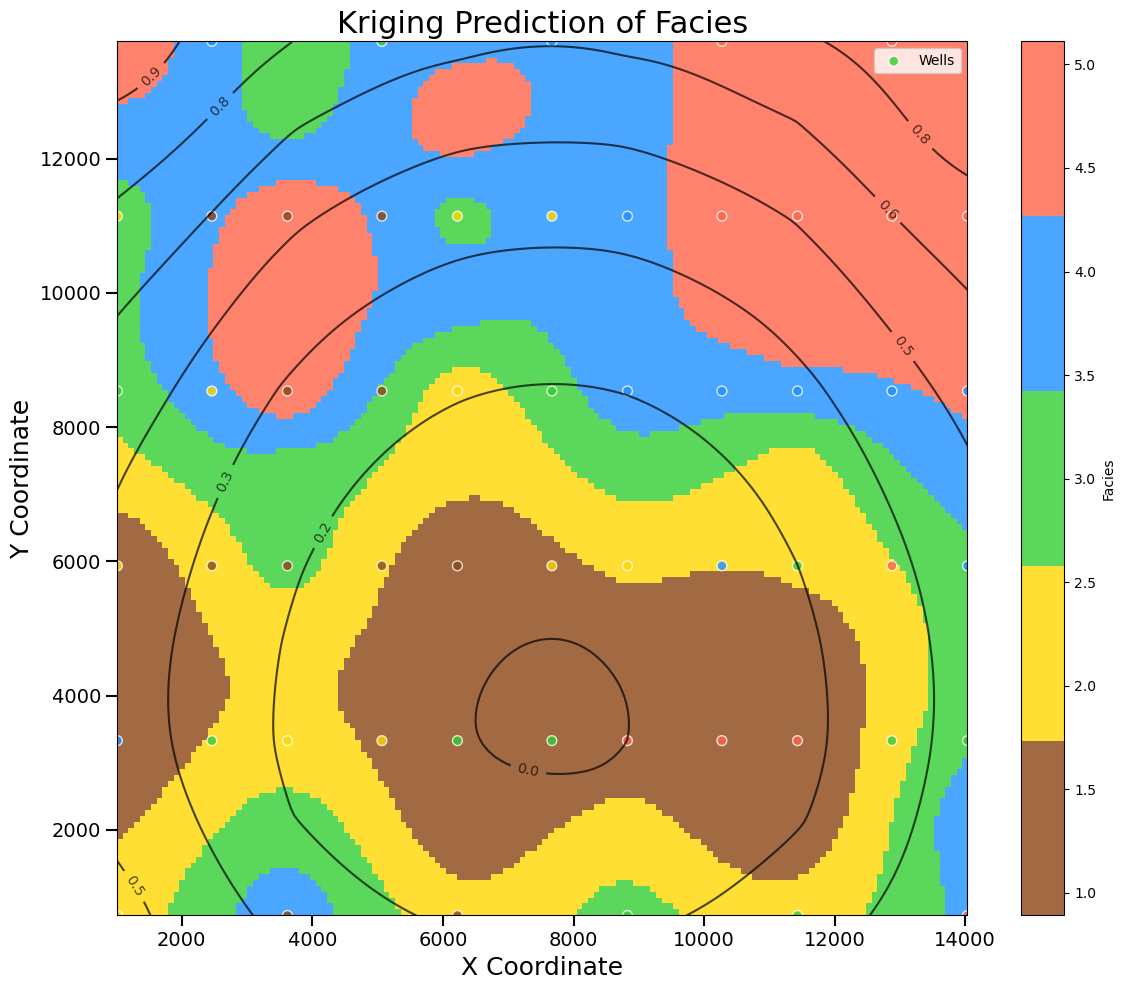

In [82]:
# Create custom colormap for facies
facies_colors = ['#8B4513', '#FFD700', '#32CD32', '#1E90FF', '#FF6347']
facies_cmap = ListedColormap(facies_colors[:len(np.unique(y))])

create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'facies', 
                    'Kriging Prediction of Facies',
                    cmap=facies_cmap, add_contours=True, contour_col='total_depth_md')
plt.show()

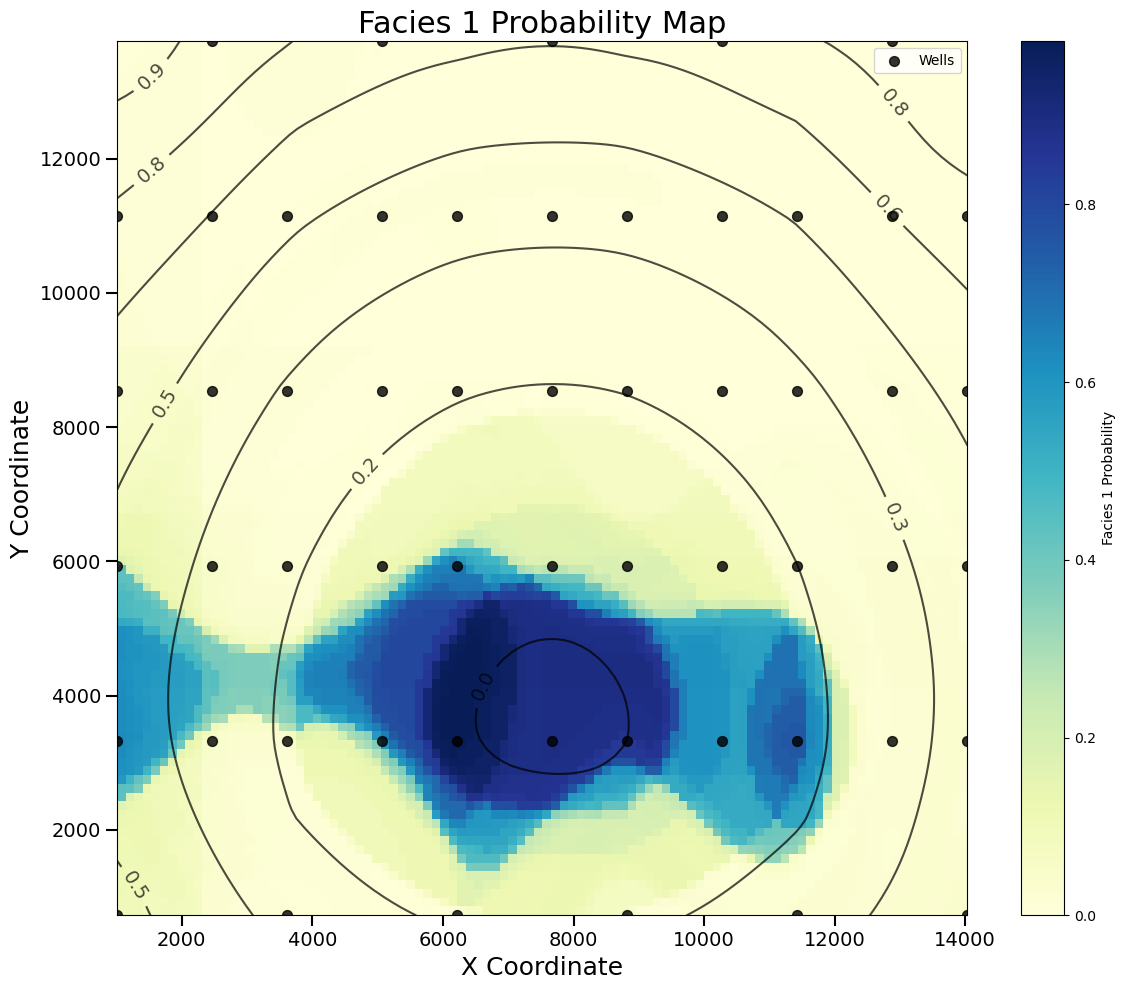

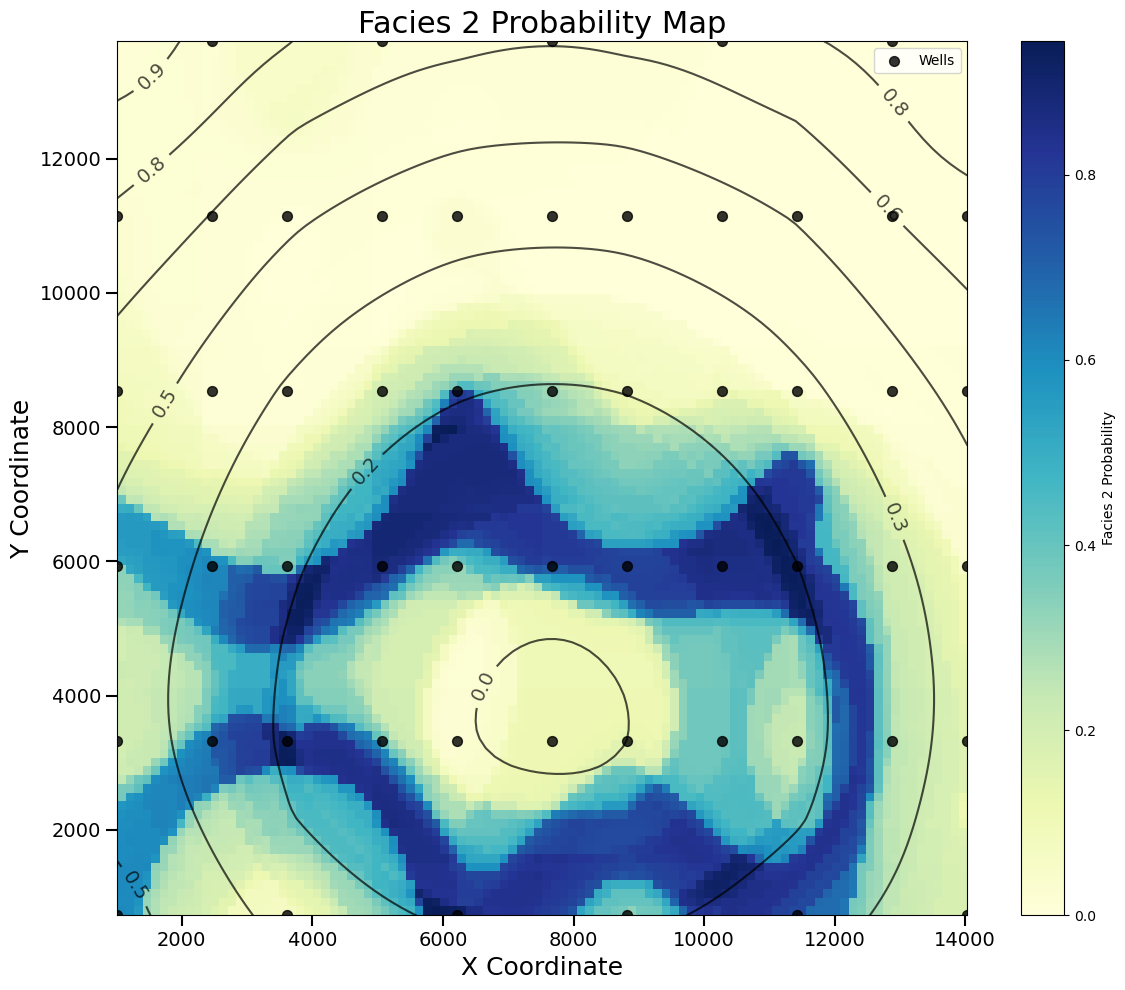

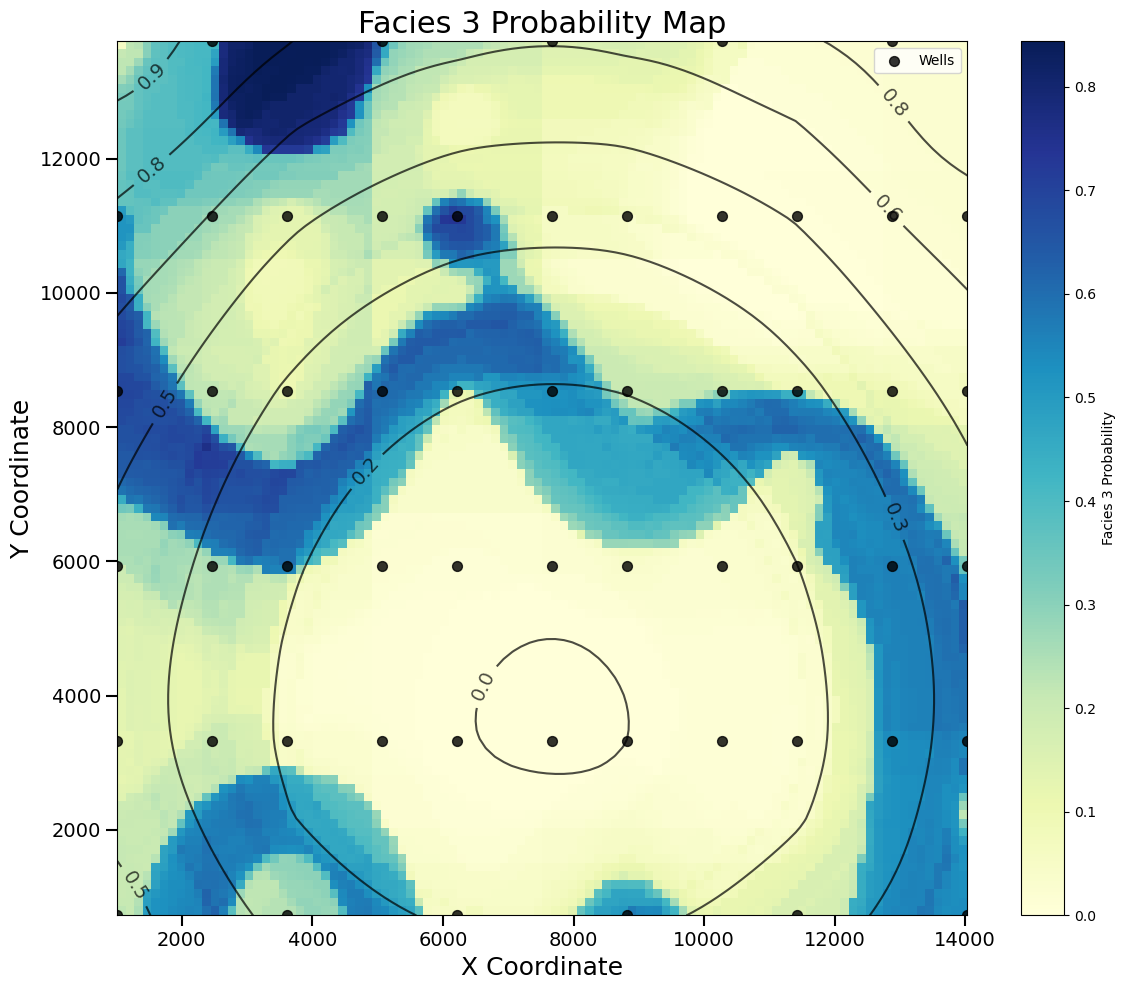

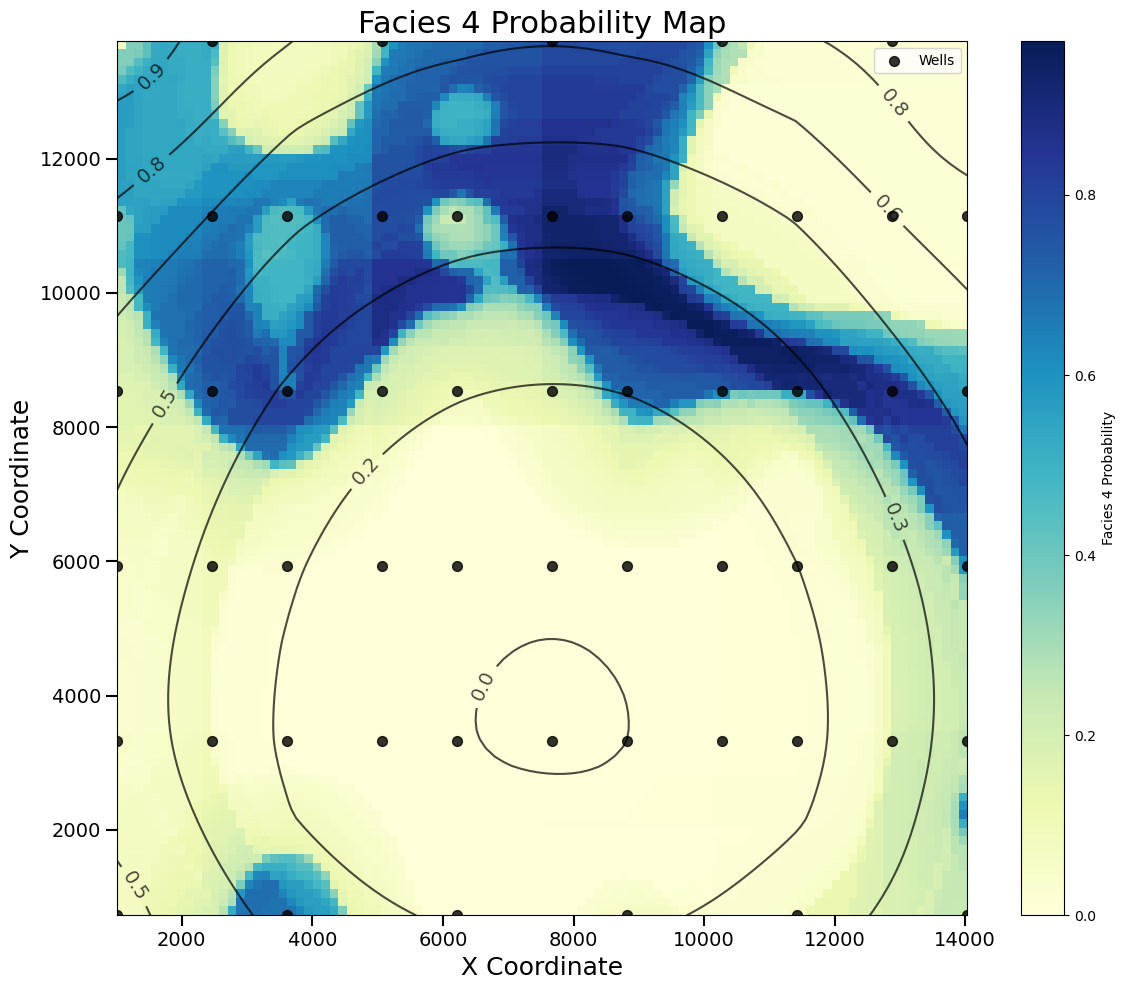

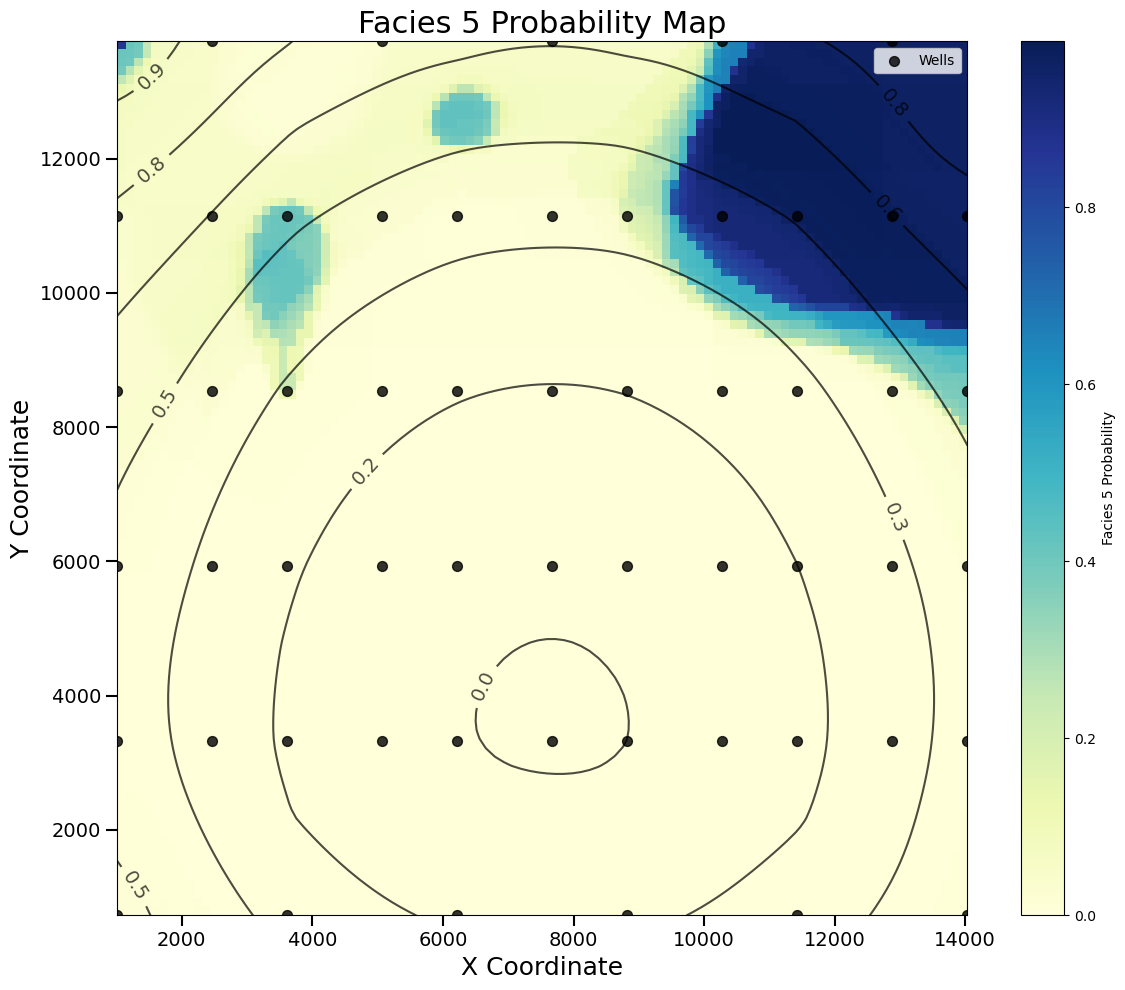

In [83]:
for idx, facies_class in enumerate(rf_classifier.classes_):
    # Prepare grid for plotting
    grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 100)
    grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 100)
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

    # Reshape facies probability to grid
    facies_proba_grid = facies_proba[:, idx].reshape(grid_xx.shape) 

    # Prepare kriging field for contours
    contour_x = df_scaled['bh_x'].values
    contour_y = df_scaled['bh_y'].values
    contour_z = df_scaled['total_depth_md'].values
    mask = ~(np.isnan(contour_x) | np.isnan(contour_y) | np.isnan(contour_z))
    contour_x, contour_y, contour_z = contour_x[mask], contour_y[mask], contour_z[mask]

    OK_contour = OrdinaryKriging(
        contour_x, contour_y, contour_z, variogram_model='spherical',
        verbose=False, enable_plotting=False
    )
    contour_pred, _ = OK_contour.execute('grid', grid_x, grid_y)

    # Plot facies probability field
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(
        facies_proba_grid.T,
        extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
        origin='lower',
        cmap='YlGnBu',   
        aspect='auto'
    )
    plt.colorbar(im, ax=ax, label=f'Facies {rf_classifier.classes_[idx]} Probability')

    # Overlay wells
    ax.scatter(
        df_scaled['bh_x'], df_scaled['bh_y'],
        c='black', s=50, linewidth=1, alpha=0.8, label='Wells'
    )

    # Add kriged depth contours
    contours = ax.contour(
        grid_x, grid_y, contour_pred.T,
        colors='black', linewidths=1.5, levels=8, alpha=0.7
    )
    ax.clabel(contours, inline=True, fontsize=14, fmt='%0.1f')

    # Labels and layout
    ax.set_xlabel('X Coordinate', fontsize=18)
    ax.set_ylabel('Y Coordinate', fontsize=18)
    ax.set_title(f'Facies {rf_classifier.classes_[idx]} Probability Map', fontsize=22)
    ax.legend()
    ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
    plt.tight_layout()
    plt.show()

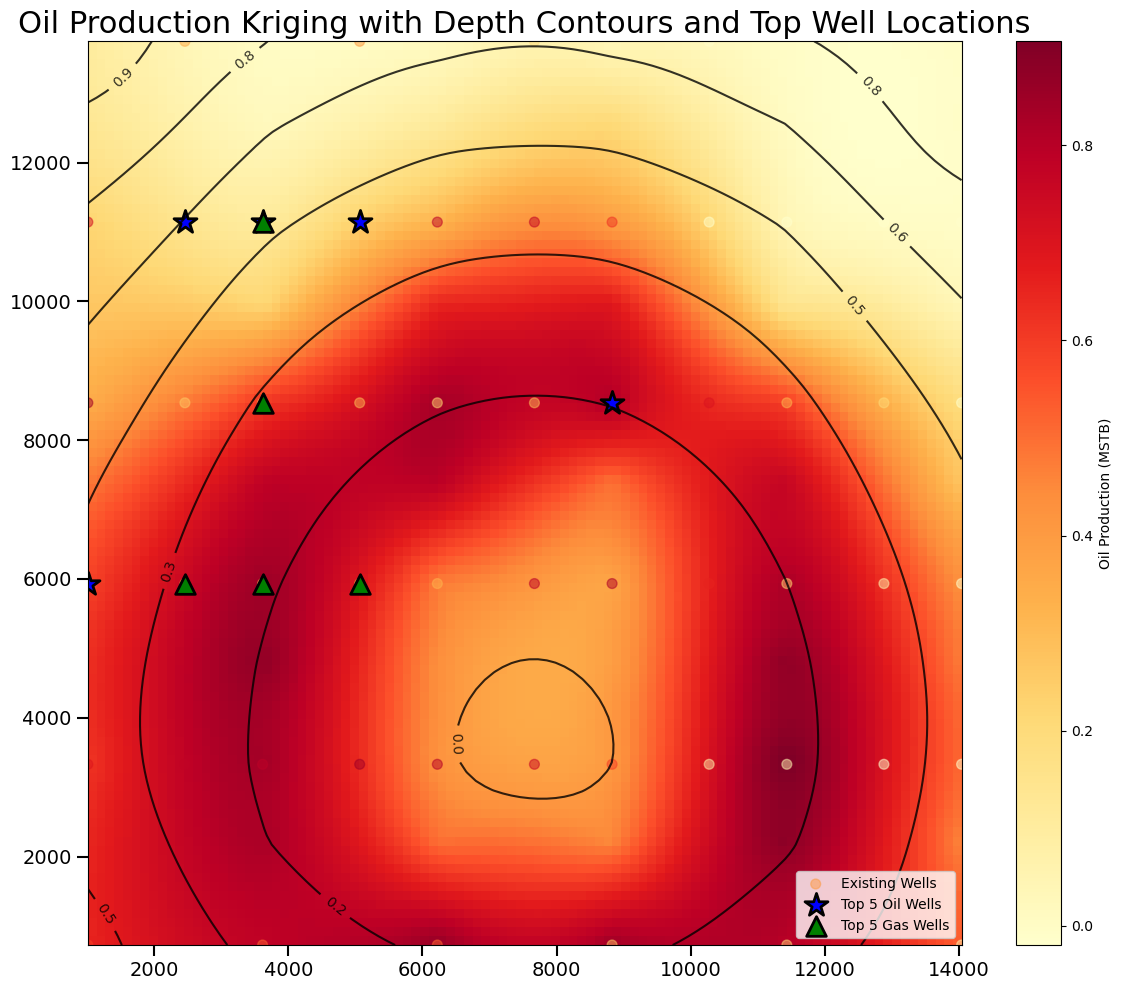

In [84]:
# Identify top wells
top_oil = df_scaled.nlargest(5, 'oil_prod_mstb')
top_gas = df_scaled.nlargest(5, 'gas_prod_mmcf')

# Create composite kriging plot with top wells marked
x = df['bh_x'].values
y = df['bh_y'].values
z = df_scaled['oil_prod_mstb'].values

mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
x, y, z = x[mask], y[mask], z[mask]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)

OK = OrdinaryKriging(x, y, z, variogram_model='spherical',
                     verbose=False, enable_plotting=False)
z_pred, ss = OK.execute('grid', grid_x, grid_y)

fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(z_pred.T, extent=[x.min(), x.max(), y.min(), y.max()],
               origin='lower', cmap='YlOrRd', aspect='auto')
plt.colorbar(im, ax=ax, label='Oil Production (MSTB)')

# Add depth contours
depth = df_scaled['total_depth_md'].values
x_all = df['bh_x'].values
y_all = df['bh_y'].values

mask_depth = ~(np.isnan(x_all) | np.isnan(y_all) | np.isnan(depth))
x_depth, y_depth, z_depth = x_all[mask_depth], y_all[mask_depth], depth[mask_depth]

OK_depth = OrdinaryKriging(x_depth, y_depth, z_depth, variogram_model='spherical',
                           verbose=False, enable_plotting=False)
depth_pred, _ = OK_depth.execute('grid', grid_x, grid_y)

contours = ax.contour(grid_x, grid_y, depth_pred.T, 
                      colors='black', linewidths=1.5, levels=8, alpha=0.8)
ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

# Overlay top wells
ax.scatter(df_scaled['bh_x'], df_scaled['bh_y'], c = df_scaled['oil_prod_mstb'], cmap = 'YlOrRd',  s=50, 
           label='Existing Wells', alpha=0.5)
ax.scatter(top_oil['bh_x'], top_oil['bh_y'], c='blue', s=300, 
           marker='*', edgecolor='black', linewidth=2, label='Top 5 Oil Wells')
ax.scatter(top_gas['bh_x'], top_gas['bh_y'], c='green', s=200, 
           marker='^', edgecolor='black', linewidth=2, label='Top 5 Gas Wells')
ax.set_title('Oil Production Kriging with Depth Contours and Top Well Locations', fontsize=22)
ax.legend()
ax.tick_params(axis='both', which='major',
               labelsize=14,    
               length=8,      
               width=1.5)       
    
plt.tight_layout()

In [85]:
# Compute average production by facies
facies_production = df_scaled.groupby('facies').agg({
    'oil_prod_mstb': ['mean', 'median', 'std'],
    'gas_prod_mmcf': ['mean', 'median', 'std']
}).round(3)

print("Production Statistics by Facies:")
print(facies_production)

Production Statistics by Facies:
       oil_prod_mstb               gas_prod_mmcf              
                mean median    std          mean median    std
facies                                                        
1              0.576  0.413  0.261         0.816  0.860  0.142
2              0.756  0.869  0.243         0.591  0.593  0.109
3              0.469  0.347  0.352         0.188  0.170  0.130
4              0.470  0.400  0.330         0.139  0.130  0.118
5              0.096  0.008  0.192         0.025  0.006  0.033


In [86]:
# Create facies quality score based on historical production
facies_quality = df_scaled.groupby('facies').agg({
    'oil_prod_mstb': 'mean',
    'gas_prod_mmcf': 'mean',
    'porosity': 'mean',
    'perm_hm': 'mean'
})
# Normalize facies scores
facies_quality['quality_score'] = (
    (facies_quality['oil_prod_mstb'] / facies_quality['oil_prod_mstb'].max()) * 0.35 +
    (facies_quality['gas_prod_mmcf'] / facies_quality['gas_prod_mmcf'].max()) * 0.35 +
    (facies_quality['porosity'] / facies_quality['porosity'].max()) * 0.15 +
    (facies_quality['perm_hm'] / facies_quality['perm_hm'].max()) * 0.15
)

print("\nFacies Quality Scores:")
print(facies_quality['quality_score'].sort_values(ascending=False))


Facies Quality Scores:
facies
1    0.916848
2    0.843851
3    0.460190
4    0.378507
5    0.079254
Name: quality_score, dtype: float64


In [87]:
# Map facies quality back to dataframe
df_scaled['facies_quality'] = df_scaled['facies'].map(facies_quality['quality_score'])

In [88]:
# Train Random Forest Classifier for facies prediction
feature_cols = ['total_depth_md', 'porosity', 'perm_hm', 'past_pressure']
X_facies = df_scaled[feature_cols].fillna(df_scaled[feature_cols].median())
y_facies = df_scaled['facies']

rf_facies = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)

rf_facies.fit(X_facies, y_facies)
print(f"\nFacies Classifier Training Accuracy: {rf_facies.score(X_facies, y_facies):.3f}")


Facies Classifier Training Accuracy: 1.000


In [89]:
# Define composite production target
df_scaled['target_production'] = df_scaled['oil_prod_mstb'] + (df_scaled['gas_prod_mmcf'])

# Features including facies information
production_features = ['total_depth_md', 'porosity', 
                       'perm_hm', 'past_pressure']

X_prod = df_scaled[production_features].fillna(df_scaled[production_features].median())
y_prod = df_scaled['target_production']

In [90]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_prod, y_prod)

# Cross-validation
cv_scores = cross_val_score(xgb_model, X_prod, y_prod, cv=5, scoring='r2')
print(f"\nProduction Model CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


Production Model CV R²: 0.785 (+/- 0.134)


In [91]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': production_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance for Production:")
print(feature_importance)


Feature Importance for Production:
          feature  importance
3   past_pressure    0.443301
0  total_depth_md    0.249102
1        porosity    0.159972
2         perm_hm    0.147625


In [92]:
# Create spatial grid
x_min, x_max = df['bh_x'].min(), df['bh_x'].max()
y_min, y_max = df['bh_y'].min(), df['bh_y'].max()

grid_x = np.linspace(x_min, x_max, 150)
grid_y = np.linspace(y_min, y_max, 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

print("\nKriging features to grid...")
grid_depth = krige_to_grid(df, 'total_depth_md', grid_x, grid_y)
grid_porosity = krige_to_grid(df, 'porosity', grid_x, grid_y)
grid_perm = krige_to_grid(df, 'perm_hm', grid_x, grid_y)
grid_pressure = krige_to_grid(df, 'past_pressure', grid_x, grid_y)


Kriging features to grid...


In [93]:
# Predict facies on grid
grid_features_facies = np.column_stack([
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel()
])

predicted_facies = rf_facies.predict(grid_features_facies)
predicted_facies_grid = predicted_facies.reshape(grid_xx.shape)

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [94]:
# Map facies to quality scores
facies_quality_grid = np.vectorize(facies_quality['quality_score'].to_dict().get)(predicted_facies_grid)

In [95]:
# Predict production on grid using facies quality
grid_features_production = np.column_stack([
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel(),
])

predicted_production = xgb_model.predict(grid_features_production)
predicted_production_grid = predicted_production.reshape(grid_xx.shape)

In [96]:
# Normalize to sweet spot score (0-1)
sweet_spot_score = (predicted_production_grid - predicted_production_grid.min()) / \
                   (predicted_production_grid.max() - predicted_production_grid.min())

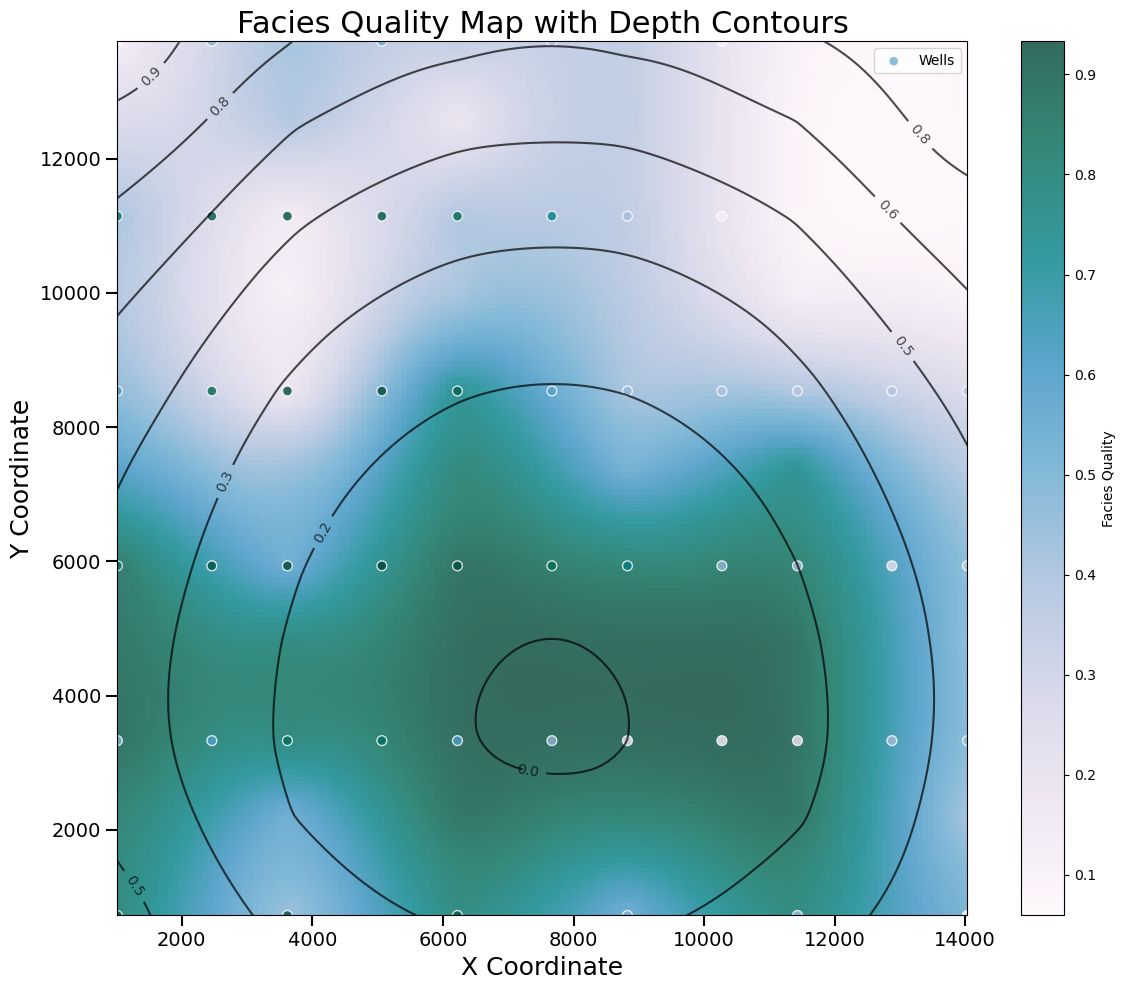

In [97]:
#Add facies quality to dataframe for plotting
df_scaled['facies_quality'] = df_scaled['facies'].map(facies_quality['quality_score'])
# Plot facies quality map with contours
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'facies_quality',
                    'Facies Quality Map with Depth Contours',
                    cmap='PuBuGn', add_contours=True, contour_col='total_depth_md')
plt.show()

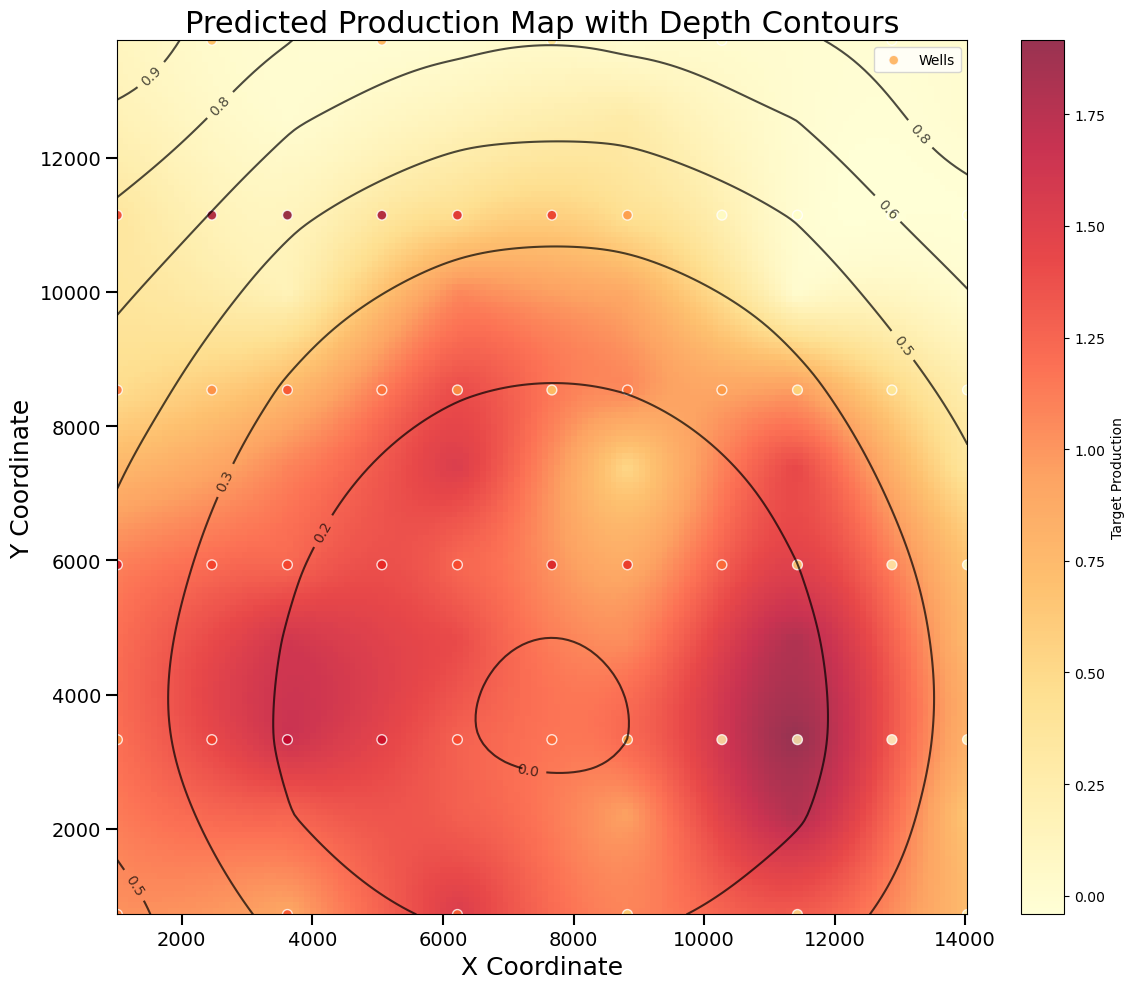

In [ ]:
# Add predicted production to dataframe for plotting
df_scaled['target_production'] = df_scaled['oil_prod_mstb'] + df_scaled['gas_prod_mmcf']
# Plot predicted production with depth contours
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'target_production',
                    'Predicted Production Map with Depth Contours',
                    cmap='YlOrRd', add_contours=True, contour_col='total_depth_md')
plt.tight_layout()
plt.show()

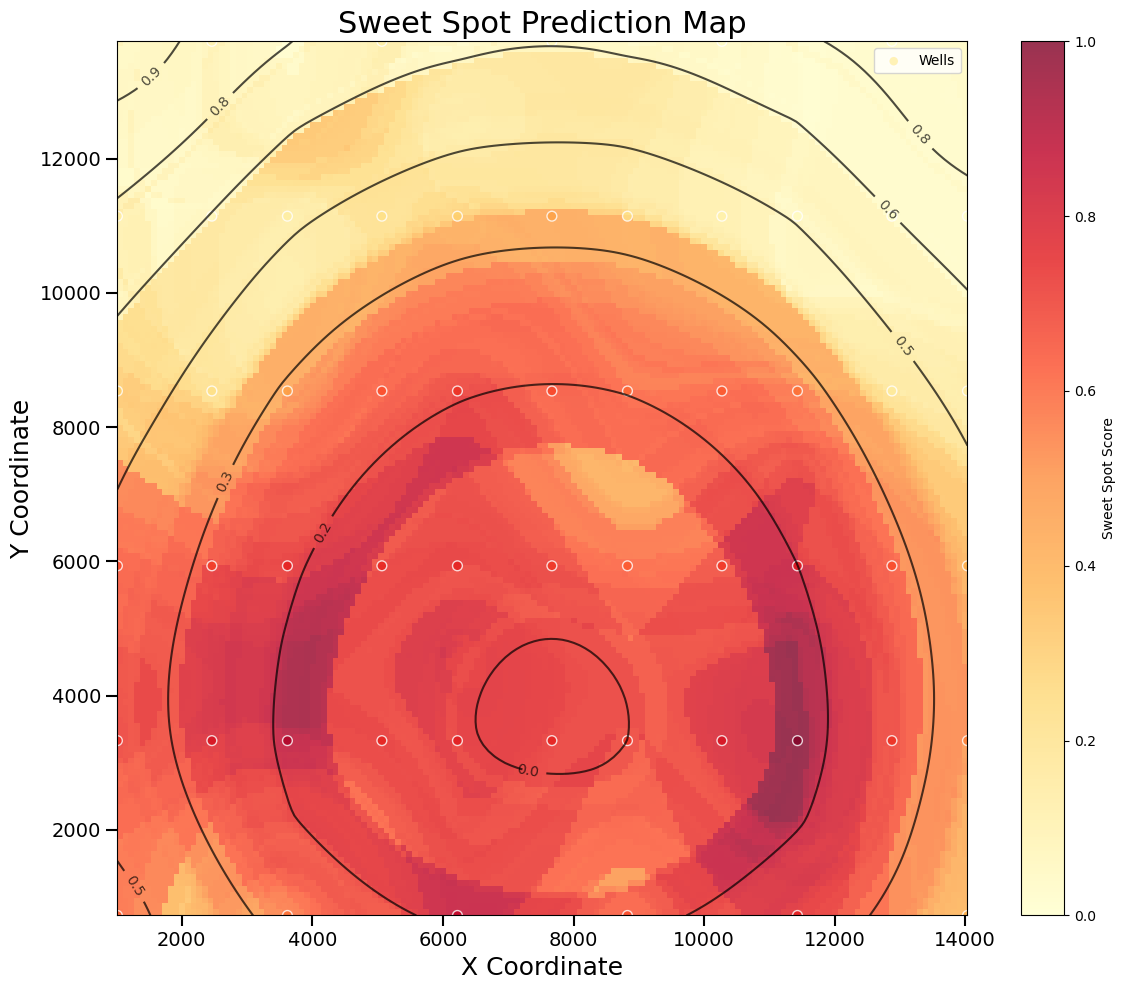

In [ ]:
# Prepare grids
grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 150)
grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Prepare kriged grids
depth_grid = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)        
sweet_spot_score_grid = sweet_spot_score.reshape(grid_xx.shape)              

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    sweet_spot_score_grid.T,                                                   
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    origin='lower',
    cmap='YlOrRd',
    aspect='auto',
    alpha=0.8
)
plt.colorbar(im, ax=ax, label='Sweet Spot Score')

# Get grid indices for wells
x_idx = np.searchsorted(grid_x, df_scaled['bh_x'])
y_idx = np.searchsorted(grid_y, df_scaled['bh_y'])
x_idx = np.clip(x_idx, 0, len(grid_x) - 1)
y_idx = np.clip(y_idx, 0, len(grid_y) - 1)

# Color wells by sweet spot scores 
well_scores = sweet_spot_score_grid[x_idx, y_idx]

ax.scatter(
    df_scaled['bh_x'], df_scaled['bh_y'],
    c=sweet_spot_score_grid[x_idx, y_idx],
    cmap='YlOrRd',
    s=50, edgecolor='white', linewidth=1, alpha=0.8, label='Wells'
)
# Add depth contours
OK_depth = OrdinaryKriging(
    df_scaled['bh_x'], df_scaled['bh_y'], df_scaled['total_depth_md'],
    variogram_model='spherical', verbose=False, enable_plotting=False
)
depth_pred, _ = OK_depth.execute('grid', grid_x, grid_y)
contours = ax.contour(
    grid_x, grid_y, depth_pred.T,
    colors='black', linewidths=1.5, levels=8, alpha=0.7
)
ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

# Formatting
ax.set_xlabel('X Coordinate', fontsize=18)
ax.set_ylabel('Y Coordinate', fontsize=18)
ax.set_title('Sweet Spot Prediction Map', fontsize=22)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tight_layout()
plt.show()

In [ ]:
# Identify sweet spots
coordinates = peak_local_max(sweet_spot_score, min_distance=10, threshold_abs=0.8)

# Map back to real coordinates
top_bh_x = grid_x[coordinates[:, 0]]
top_bh_y = grid_y[coordinates[:, 1]]
top_scores = sweet_spot_score[coordinates[:, 0], coordinates[:, 1]]
print("Top Sweet Spots (X, Y, Score):")
for x, y, score in zip(top_bh_x, top_bh_y, top_scores):
    print(f"({x:.2f}, {y:.2f}) - Score: {score:.3f}")

Top Sweet Spots (X, Y, Score):
(11150.59, 2996.69) - Score: 1.000
(11325.38, 4657.19) - Score: 0.997
(3809.44, 3521.06) - Score: 0.948
(6169.09, 7366.42) - Score: 0.864
(5994.30, 4569.79) - Score: 0.838


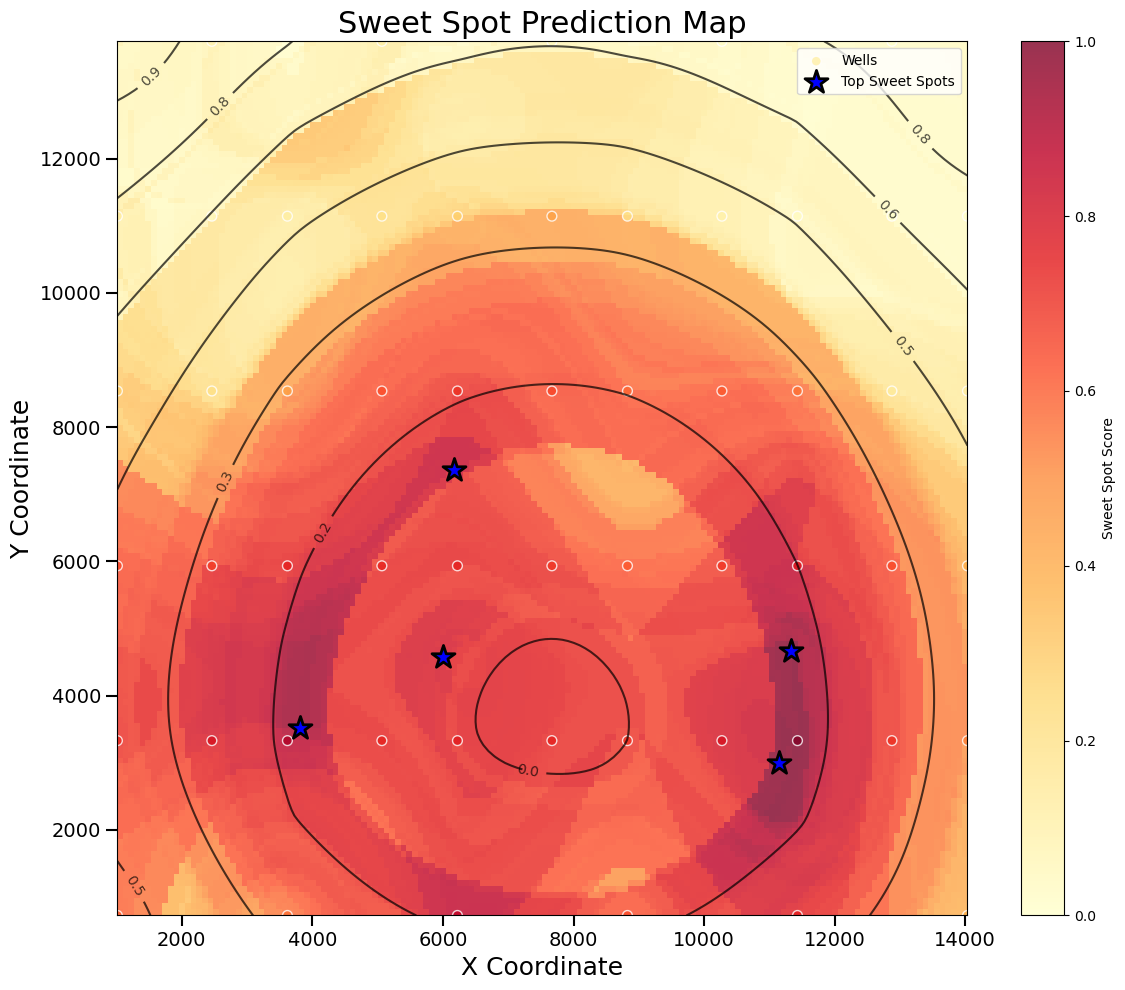

In [ ]:
# Prepare grids
grid_x = np.linspace(df_scaled['bh_x'].min(), df_scaled['bh_x'].max(), 150)
grid_y = np.linspace(df_scaled['bh_y'].min(), df_scaled['bh_y'].max(), 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Prepare kriged grids
depth_grid = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)        
sweet_spot_score_grid = sweet_spot_score.reshape(grid_xx.shape)              

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(
    sweet_spot_score_grid.T,                                                   
    extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
    origin='lower',
    cmap='YlOrRd',
    aspect='auto',
    alpha=0.8
)
plt.colorbar(im, ax=ax, label='Sweet Spot Score')

# Get grid indices for wells
x_idx = np.searchsorted(grid_x, df_scaled['bh_x'])
y_idx = np.searchsorted(grid_y, df_scaled['bh_y'])
x_idx = np.clip(x_idx, 0, len(grid_x) - 1)
y_idx = np.clip(y_idx, 0, len(grid_y) - 1)

# Color wells by sweet spot scores 
well_scores = sweet_spot_score_grid[x_idx, y_idx]

ax.scatter(
    df_scaled['bh_x'], df_scaled['bh_y'],
    c=sweet_spot_score_grid[x_idx, y_idx],
    cmap='YlOrRd',
    s=50, edgecolor='white', linewidth=1, alpha=0.8, label='Wells'
)
ax.scatter(
    top_bh_x, top_bh_y,
    c='blue', s=300, marker='*', edgecolor='black', linewidth=2, label='Top Sweet Spots'
)
# Add contours
contours = ax.contour(
    grid_x, grid_y, depth_grid.T,
    colors='black', linewidths=1.5, levels=8, alpha=0.7
)
ax.clabel(contours, inline=True, fontsize=10, fmt='%0.1f')

# Formatting
ax.set_xlabel('X Coordinate', fontsize=18)
ax.set_ylabel('Y Coordinate', fontsize=18)
ax.set_title('Sweet Spot Prediction Map', fontsize=22)
ax.legend()
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=1.5)
plt.tight_layout()
plt.show()